Nous utiliserons dans ce notebook le jeu de données *Adult Census*, qui est disponible sur le UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/adult). Il consiste à prédire une variable binaire (bas ou haut revenu) qui correspond à un revenu inférieur ou supérieur à 50 000 dollars par an. Cette décision peut être utilisée pour évaluer le risque de crédit. Les variables $X$ et le véritable résultat $Y$ étant disponibles, des algorithmes d'apprentissage automatique supervisé seront utilisés pour évaluer si les décisions peuvent être considérées comme discriminantes.

Au total, 48 842 individus sont décrits par 14 variables. Chargeons et examinons rapidement cet ensemble de données.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk


original_data_train = pd.read_csv(
    "./adult_dataset/adult.data.csv",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "OrigEthn", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
    sep=r'\s*,\s*',
    engine='python',
    na_values="?")

original_data_test = pd.read_csv(
    "./adult_dataset/adult.test.csv",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "OrigEthn", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
    sep=r'\s*,\s*',
    engine='python',
    na_values="?")


original_data = pd.concat([original_data_test,original_data_train])
original_data.reset_index(inplace = True, drop = True)

original_data.tail()


Age     Workclass  fnlwgt   Education  Education-Num  \
48837   27       Private  257302  Assoc-acdm             12   
48838   40       Private  154374     HS-grad              9   
48839   58       Private  151910     HS-grad              9   
48840   22       Private  201490     HS-grad              9   
48841   52  Self-emp-inc  287927     HS-grad              9   

           Martial Status         Occupation Relationship OrigEthn     Sex  \
48837  Married-civ-spouse       Tech-support         Wife    White  Female   
48838  Married-civ-spouse  Machine-op-inspct      Husband    White    Male   
48839             Widowed       Adm-clerical    Unmarried    White  Female   
48840       Never-married       Adm-clerical    Own-child    White    Male   
48841  Married-civ-spouse    Exec-managerial         Wife    White  Female   

       Capital Gain  Capital Loss  Hours per week        Country Target  
48837             0             0              38  United-States  <=50K  
48838             0             0              40  United-States   >50K  
48839             0             0              40  United-States  <=50K  
48840             0             0              20  United-States  <=50K  
48841         15024             0              40  United-States   >50K

Nous pouvons également tracer la distribution de chaque caractéristique, afin de mieux comprendre ce que nous avons dans nos données. Nous dessinons le nombre de valeurs pour chaque caractéristique catégorielle et l'histogramme des valeurs pour chaque caractéristique continue.

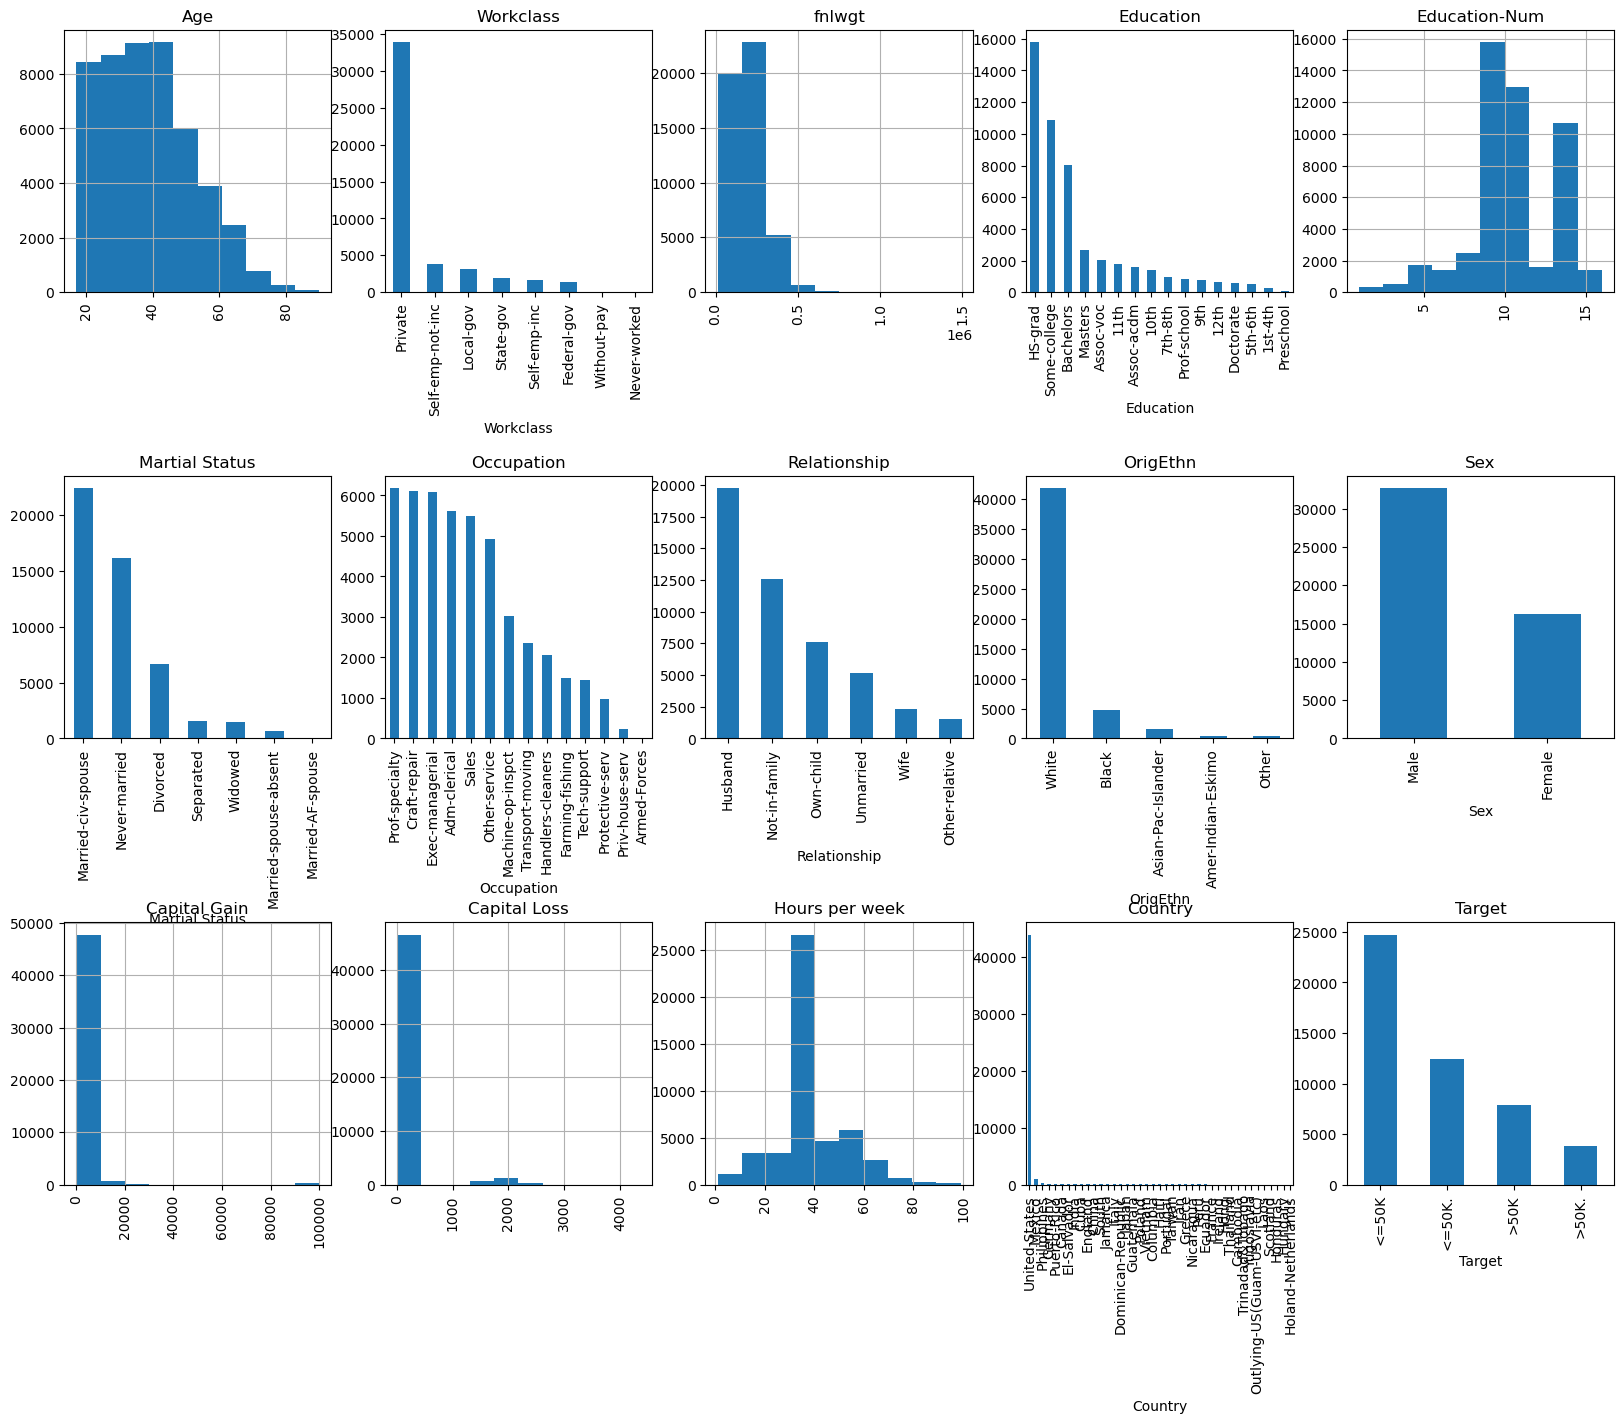

In [2]:
fig = plt.figure(figsize=(20, 15))
cols = 5
rows = int(np.ceil(float(original_data.shape[1]) / cols))

for i, column in enumerate(original_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if original_data.dtypes[column] == 'object':  # Use 'object' instead of np.object
        original_data[column].value_counts().plot(kind="bar", ax=ax)
    else:
        original_data[column].hist(ax=ax)  # Correct 'axes' to 'ax'
        plt.xticks(rotation="vertical")

plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

Cette représentation des données donne un bon aperçu de ce que les données contiennent. Elle montre aussi clairement qu'il doit être pré-traité avant d'être analysé à l'aide d'algorithmes d'apprentissage automatique de boîte noire. Par exemple, la variable <i>"fnlwgt"</i> n'a pas d'interprétation claire et deux étiquettes seulement auraient plus de sens que quatre dans la variable <i>"Target"</i>. Une variable comme <i>"Country"</i> (voir ci-dessous) semble également trop raffinée pour capturer les discriminations potentielles, de sorte qu'il est raisonnable de n'utiliser que la variable <i>"OrigEthn"</i>.

In [3]:
(original_data["Country"].value_counts() / original_data.shape[0]).head()

Country
United-States    0.897424
Mexico           0.019471
Philippines      0.006040
Germany          0.004218
Puerto-Rico      0.003767
Name: count, dtype: float64

***
## 1 Analyse Statistique du jeu de données
***

### 1.1 Préparation des données

Comme indiqué dans l'introduction, nous allons d'abord préparer les données afin de donner une interprétation claire aux analyses ultérieures. La variable fnlwgt (Final sampling weight) (http://web.cs.wpi.edu/~cs4341/C00/Projects/fnlwgt) n'a pas de signification claire, elle sera donc supprimée. Les données manquantes seront supprimées, certaines données incohérentes seront remplacées, les variables redondantes seront supprimées et certaines classes seront finalement regroupées pour obtenir un meilleur aperçu statistique. 


Ces modifications sont appliquées dans la cellule ci-dessous :
- La variable binaire "Enfant" est créée. Elle indique si la personne a des enfants ou non.
- La variable "Child" est transformée en variable binaire : "CaucYes" vs. "CaucNo".
- La variable "fnlwgt" est supprimée, car sa signification n'est pas claire.
- La variable "Country" est supprimée car elle est redondante avec la variable "OrigEthn".
- La variable "Education" est supprimée car elle est redondante avec la variable "Education-Num".
- La variable "Relationship" est supprimée car elle est redondante avec la variable "Martial Status".
- En outre, les variables <=50K, <=50K, >50K et >50K de la variable "Target" sont nettoyées.


In [4]:
data=original_data.copy()


data['Child'] = np.where(data['Relationship']=='Own-child', 'ChildYes', 'ChildNo')
data['OrigEthn'] = np.where(data['OrigEthn']=='White', 'CaucYes', 'CaucNo')

data=data.drop(columns=['fnlwgt','Relationship','Country','Education'])

data=data.replace('<=50K.','<=50K')
data=data.replace('>50K.','>50K')

data.tail()


Age     Workclass  Education-Num      Martial Status  \
48837   27       Private             12  Married-civ-spouse   
48838   40       Private              9  Married-civ-spouse   
48839   58       Private              9             Widowed   
48840   22       Private              9       Never-married   
48841   52  Self-emp-inc              9  Married-civ-spouse   

              Occupation OrigEthn     Sex  Capital Gain  Capital Loss  \
48837       Tech-support  CaucYes  Female             0             0   
48838  Machine-op-inspct  CaucYes    Male             0             0   
48839       Adm-clerical  CaucYes  Female             0             0   
48840       Adm-clerical  CaucYes    Male             0             0   
48841    Exec-managerial  CaucYes  Female         15024             0   

       Hours per week Target     Child  
48837              38  <=50K   ChildNo  
48838              40   >50K   ChildNo  
48839              40  <=50K   ChildNo  
48840              20  <=50K  ChildYes  
48841              40   >50K   ChildNo

/var/folders/kh/kbhx2yr91hd_wwr16v28mdl40000gn/T/ipykernel_23533/3751731551.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation="vertical")
/var/folders/kh/kbhx2yr91hd_wwr16v28mdl40000gn/T/ipykernel_23533/3751731551.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation="vertical")
/var/folders/kh/kbhx2yr91hd_wwr16v28mdl40000gn/T/ipykernel_23533/3751731551.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation="vertical")
/var/folders/kh/kbhx2yr91hd_wwr16v28mdl40000gn/T/ipykernel_23533/3751731551.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

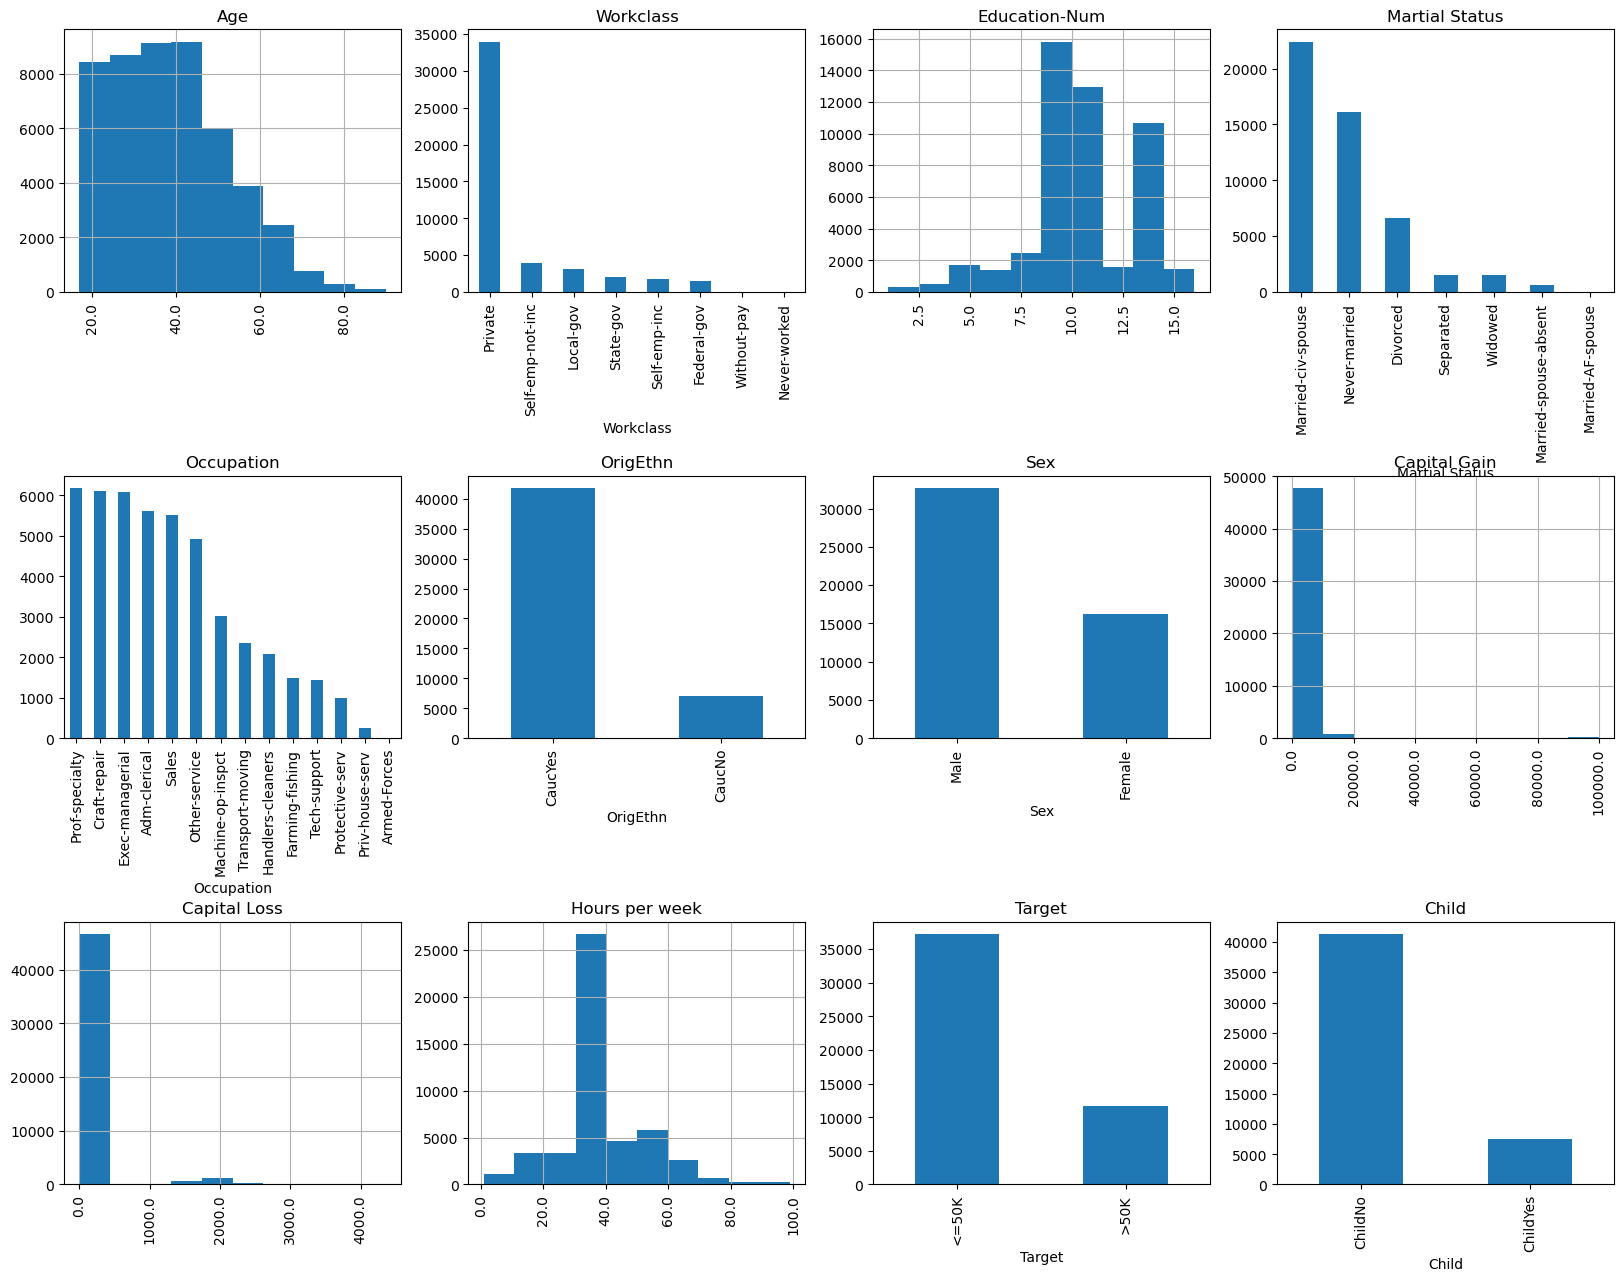

In [5]:
fig = plt.figure(figsize=(20, 15))
cols = 4
rows = int(np.ceil(float(data.shape[1]) / cols))

for i, column in enumerate(data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data.dtypes[column] == 'object':  # Use 'object' instead of np.object
        data[column].value_counts().plot(kind="bar", ax=ax)  # Correct 'axes' to 'ax'
    else:
        data[column].hist(ax=ax)  # Correct 'axes' to 'ax'
        ax.set_xticklabels(ax.get_xticks(), rotation="vertical")

plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

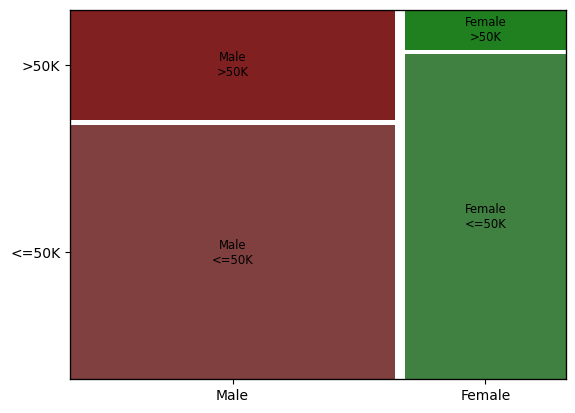

In [12]:
from statsmodels.graphics.mosaicplot import mosaic

mosaic(data, ['Sex','Target'],gap=0.02)
plt.show()


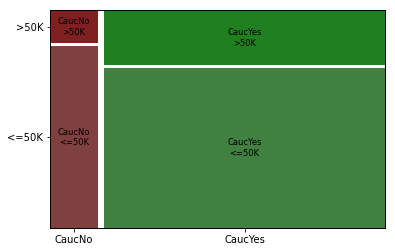

In [7]:

mosaic(data, index=['OrigEthn','Target' ],gap=0.02)
plt.show()

In [6]:
def categorical_variables(data):
    l1 = list(data.select_dtypes(include = ["category"]).columns)
    l2 = [ft for ft in data.columns if data[ft].dtype == pd.CategoricalDtype]
    return l1+l2

print(list(data.columns))
print(categorical_variables(data))

col_cont = ['Age', 'Education-Num', 'Hours per week', 'Capital Gain', 'Capital Loss', 'Target','Sex']
#colonnes à valeurs réelles, 
#même en retirant les deux colonnes booléennes: Target et Sex, nous obtenons dans la suite des résultats similaires

['Age', 'Workclass', 'Education-Num', 'Martial Status', 'Occupation', 'OrigEthn', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Target', 'Child']
['Workclass', 'Martial Status', 'Occupation', 'OrigEthn', 'Sex', 'Target', 'Child']


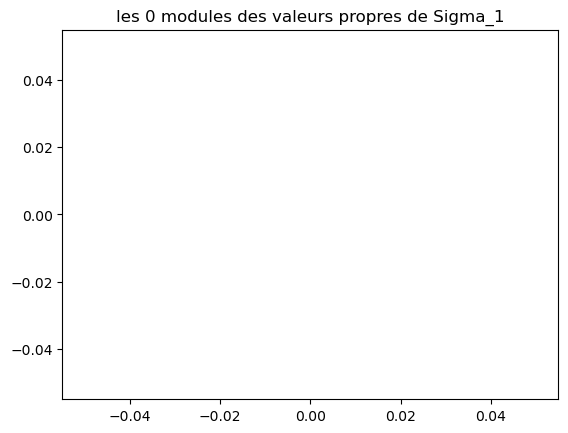

ValueError: min() arg is an empty sequence

In [7]:
dt1 = data[data['Sex'] ==1]
valp1 = np.linalg.eig(np.matmul(np.array(dt1[col_cont], dtype = float),
                               np.array(dt1[col_cont], dtype = float).transpose())
                     /len(dt1))[0]
caract = "les " + str(len(dt1)) + " modules des valeurs propres de Sigma_1"

l1_mod = [np.linalg.norm(valp1[i])for i in range(len(valp1))]
plt.plot(np.log(np.sort(l1_mod)), lw = 0, marker = 'o')
plt.title(caract)
plt.show()
print("min des modules des val-p:",min(l1_mod))

### 1.3 Conclusion

Quelle est l'information que l'on peut tirer des données ? Une relation entre les variables et les <i>Capital Gains</i> qui permettra de les prévoir, ou le simple biais dans la répartition des <i>Capital Gains</i> par rapport aux variables <i>sex</i> et <i>ethnic origin</i>, en raison d'un ensemble de données déséquilibrées ?


***
## 2 Algorithmes d'apprentissage pour prédire l'acceptation d'un dossier
***

Nous allons comparer les modèles de prédiction suivants :

<ul>
  <li>Logistic regression.</li>
  <li>Decision tree.</li>
  <li>Gradient boosting.</li>
</ul>

Nous utiliserons Scikit-Learn pour la régression logistique et les arbres de décisions (https://scikit-learn.org/stable/install.html), ainsi que la bibliothèque lightgbm pour l'algorithme de gradient boosting (https://anaconda.org/conda-forge/lightgbm).

### 2.1 Formater les données

Les données contienent des variables quantitatives et categoriellles. Afin d'analyser les variables catégorielles, nous allons :
<ul>
<li>Les variables binaires seront codées avec des 0 ou 1. </li>
<li>Les variables catégorielles comportant plus de deux classes seront transformées en vecteurs de type <i>one-hot encoding</i>, c'est-à-dire des vecteurs dont un seul élément est non nul (ou chaud/hot).</li>
<ul>


In [9]:
data_ohe=data.copy()

data_ohe['Target'] = np.where(data_ohe['Target']=='>50K', 1., 0.)
print('\n -> In column Target: label >50K gets 1.')

data_ohe['OrigEthn'] = np.where(data_ohe['OrigEthn']=='CaucYes', 1., 0.)
print('\n -> In column '+str('OrigEthn')+': label '+str('CaucYes')+' gets 1.')

data_ohe['Sex'] = np.where(data_ohe['Sex']=='Male', 1., 0.)
print('\n -> In column '+str('Sex')+': label '+str('Male')+' gets 1.')

for col in ['Workclass', 'Martial Status', 'Occupation', 'Child']:
    if len(set(list(data_ohe[col])))==2:
        LabelThatGets1=data_ohe[col][0]
        data_ohe[col] = np.where(data_ohe[col]==LabelThatGets1, 1., 0.)
        print('\n -> In column '+str(col)+': label '+str(LabelThatGets1)+' gets 1.')
    else:
        print('\n -> In column '+str(col)+': one-hot encoding conversion with labels '+str(set(list(data_ohe[col]))))
        data_ohe=pd.get_dummies(data_ohe,prefix=[col],columns=[col])



 -> In column Target: label >50K gets 1.

 -> In column OrigEthn: label CaucYes gets 1.

 -> In column Sex: label Male gets 1.

 -> In column Workclass: one-hot encoding conversion with labels {'Local-gov', 'State-gov', 'Self-emp-inc', 'Private', 'Without-pay', 'Never-worked', nan, 'Federal-gov', 'Self-emp-not-inc'}

 -> In column Martial Status: one-hot encoding conversion with labels {'Divorced', 'Married-AF-spouse', 'Never-married', 'Separated', 'Married-spouse-absent', 'Married-civ-spouse', 'Widowed'}

 -> In column Occupation: one-hot encoding conversion with labels {'Prof-specialty', 'Sales', 'Transport-moving', 'Farming-fishing', 'Tech-support', 'Armed-Forces', 'Adm-clerical', 'Exec-managerial', 'Other-service', 'Priv-house-serv', 'Handlers-cleaners', nan, 'Machine-op-inspct', 'Craft-repair', 'Protective-serv'}

 -> In column Child: label ChildYes gets 1.


Voila ce à quoi ressemblent les données :

In [10]:
data_ohe.tail()

Age  Education-Num  OrigEthn  Sex  Capital Gain  Capital Loss  \
48837   27             12       1.0  0.0             0             0   
48838   40              9       1.0  1.0             0             0   
48839   58              9       1.0  0.0             0             0   
48840   22              9       1.0  1.0             0             0   
48841   52              9       1.0  0.0         15024             0   

       Hours per week  Target  Child  Workclass_Federal-gov  ...  \
48837              38     0.0    0.0                  False  ...   
48838              40     1.0    0.0                  False  ...   
48839              40     0.0    0.0                  False  ...   
48840              20     0.0    1.0                  False  ...   
48841              40     1.0    0.0                  False  ...   

       Occupation_Farming-fishing  Occupation_Handlers-cleaners  \
48837                       False                         False   
48838                       False                         False   
48839                       False                         False   
48840                       False                         False   
48841                       False                         False   

       Occupation_Machine-op-inspct  Occupation_Other-service  \
48837                         False                     False   
48838                          True                     False   
48839                         False                     False   
48840                         False                     False   
48841                         False                     False   

       Occupation_Priv-house-serv  Occupation_Prof-specialty  \
48837                       False                      False   
48838                       False                      False   
48839                       False                      False   
48840                       False                      False   
48841                       False                      False   

       Occupation_Protective-serv  Occupation_Sales  Occupation_Tech-support  \
48837                       False             False                     True   
48838                       False             False                    False   
48839                       False             False                    False   
48840                       False             False                    False   
48841                       False             False                    False   

       Occupation_Transport-moving  
48837                        False  
48838                        False  
48839                        False  
48840                        False  
48841                        False  

[5 rows x 38 columns]

Enfin, nous extrayons les matrices d'entrée et de sortie (X et y) en tant que np.arrays pour des analyses ultérieures à l'aide de sklearn. Nous divisons aussi l'ensemble des données en un échantillon d'apprentissage et un échantillon de test.

In [11]:
#extract the X and y np.arrays
y=data_ohe['Target'].values.reshape(-1,1)

data_ohe_wo_target=data_ohe.drop(columns=['Target'])

X_col_names=list(data_ohe_wo_target.columns)
X=data_ohe_wo_target.values


#split the learning and test samples
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#print the np.array shapes 
print('n_train=',X_train.shape[0])
print('n_test=',X_test.shape[0])
print('p=',X_test.shape[1])

#center-reduce the arrays X_train and X_test to make sure all variables have the same scale
X_train=sk.preprocessing.scale(X_train)
X_test_NoScaling=X_test.copy()
X_test=sk.preprocessing.scale(X_test)

n_train= 32724
n_test= 16118
p= 37


In [13]:
data_male=data_ohe[data_ohe['Sex'] == 1]
y_male = y[data_ohe['Sex'] == 1]

data_female=data_ohe[data_ohe['Sex'] == 0]
y_female = y[data_ohe['Sex'] == 0]

In [14]:
data_male_wo_target=data_male.drop(columns=['Target'])

X_male_col_names=list(data_male_wo_target.columns)
X_male=data_male_wo_target.values


#split the learning and test samples
from sklearn.model_selection import train_test_split

X_male_train, X_male_test, y_male_train, y_male_test = train_test_split(X_male, y_male, test_size=0.33)

#print the np.array shapes 
print('n_train=',X_male_train.shape[0])
print('n_test=',X_male_test.shape[0])
print('p=',X_male_test.shape[1])

#center-reduce the arrays X_train and X_test to make sure all variables have the same scale
X_male_train=sk.preprocessing.scale(X_male_train)
X_male_test_NoScaling=X_male_test.copy()
X_male_test=sk.preprocessing.scale(X_male_test)

n_train= 21875
n_test= 10775
p= 37


In [15]:

data_female_wo_target=data_female.drop(columns=['Target'])

X_female_col_names=list(data_female_wo_target.columns)
X_female=data_female_wo_target.values


#split the learning and test samples
from sklearn.model_selection import train_test_split

X_female_train, X_female_test, y_female_train, y_female_test = train_test_split(X_female, y_female, test_size=0.33)

#print the np.array shapes 
print('n_train=',X_female_train.shape[0])
print('n_test=',X_female_test.shape[0])
print('p=',X_female_test.shape[1])

#center-reduce the arrays X_train and X_test to make sure all variables have the same scale
X_female_train=sk.preprocessing.scale(X_female_train)
X_female_test_NoScaling=X_female_test.copy()
X_female_test=sk.preprocessing.scale(X_female_test)





n_train= 10848
n_test= 5344
p= 37




### 2.2 Régression Logistique

Nous effectuons d'abord un régression logistique (<i>Logistic Regression</i>) sur ces données.

In [46]:
from sklearn.linear_model import LogisticRegression

#instanciate the classifier
clf_LR = LogisticRegression(solver='lbfgs',max_iter=100)
clf_male_LR=LogisticRegression(solver='lbfgs',max_iter=10000)
clf_female_LR=LogisticRegression(solver='lbfgs',max_iter=10000)
#train the classifier
clf_LR.fit(X_train,y_train.ravel())
clf_male_LR.fit(X_male_train,y_male_train.ravel())
clf_female_LR.fit(X_female_train,y_female_train.ravel())
#predict y_test
y_test_pred_LR=clf_LR.predict(X_test)
y_male_test_pred_LR=clf_male_LR.predict(X_male_test)
y_female_test_pred_LR=clf_female_LR.predict(X_female_test)
print('Done')

Done


Maintenant que le classificateur est entraîné et que les prédictions sont faites sur l'ensemble de test, mesurons la précision des prédictions.

Nous rappelons que :
<ul>
 <li>y=0 signifie un salaire annuel sous 50K</li>
 <li>y=1 signifie un salaire annuel de plus de 50K</li>
</ul>

et qu'une matrice de confusion (C.M.) représente ici la quantité :

$$
C.M. = 
\left(
\begin{array}{cc}
True  Negatives &False  Positives\\
False  Negatives &True  Positives\\
\end{array}
\right)
$$


In [47]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

acc=accuracy_score(y_test.ravel(),y_test_pred_LR.ravel())
tpr=np.sum((y_test_pred_LR.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_test_pred_LR.ravel()==1)
tnr=np.sum((y_test_pred_LR.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_test_pred_LR.ravel()==0)

cm = metrics.confusion_matrix(y_test.ravel(),y_test_pred_LR.ravel(),labels=[0,1])

print("\nAccuracy =",acc)
print("True positive rate =",tpr)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
print("True negative rate =",tnr)
print('\nConfusion matrix ([[TN,FP],[FN,TP]]) =')
print(cm)



Accuracy = 0.8510361086983497
True positive rate = 0.7307814992025519
True negative rate = 0.8800739428483402

Confusion matrix ([[TN,FP],[FN,TP]]) =
[[11426   844]
 [ 1557  2291]]


In [49]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

acc_male=accuracy_score(y_male_test.ravel(),y_male_test_pred_LR.ravel())
tpr=np.sum((y_male_test_pred_LR.ravel()==1)*(y_male_test.ravel()==1)) / np.sum(y_male_test_pred_LR.ravel()==1)
tnr=np.sum((y_male_test_pred_LR.ravel()==0)*(y_male_test.ravel()==0)) / np.sum(y_male_test_pred_LR.ravel()==0)

cm = metrics.confusion_matrix(y_male_test.ravel(),y_male_test_pred_LR.ravel(),labels=[0,1])

print("\nAccuracy =",acc_male)
print("True positive rate =",tpr)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
print("True negative rate =",tnr)
print('\nConfusion matrix ([[TN,FP],[FN,TP]]) =')
print(cm)




Accuracy = 0.8119721577726218
True positive rate = 0.7341211225997046
True negative rate = 0.8381058633940747

Confusion matrix ([[TN,FP],[FN,TP]]) =
[[6761  720]
 [1306 1988]]


In [51]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

acc_female=accuracy_score(y_female_test.ravel(),y_female_test_pred_LR.ravel())
tpr_female=np.sum((y_female_test_pred_LR.ravel()==1)*(y_female_test.ravel()==1)) / np.sum(y_female_test_pred_LR.ravel()==1)
tnr_female=np.sum((y_female_test_pred_LR.ravel()==0)*(y_female_test.ravel()==0)) / np.sum(y_female_test_pred_LR.ravel()==0)

cm_female = metrics.confusion_matrix(y_female_test.ravel(),y_female_test_pred_LR.ravel(),labels=[0,1])

print("\nAccuracy =",acc_female)
print("True positive rate =",tpr_female)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
print("True negative rate =",tnr_female)
print('\nConfusion matrix ([[TN,FP],[FN,TP]]) =')
print(cm_female)



Accuracy = 0.9262724550898204
True positive rate = 0.7415458937198067
True negative rate = 0.9417849898580122

Confusion matrix ([[TN,FP],[FN,TP]]) =
[[4643  107]
 [ 287  307]]


In [54]:
np.sum(y_female_test.ravel()==1)

594

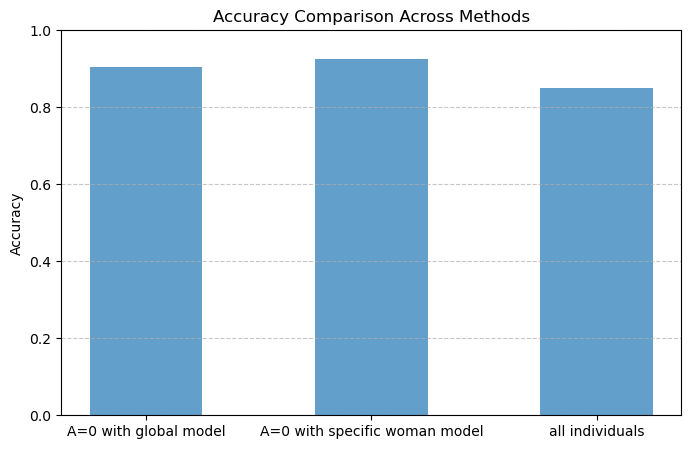

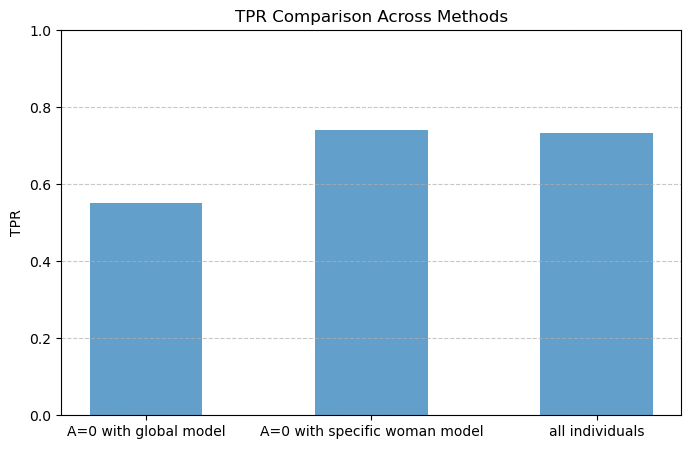

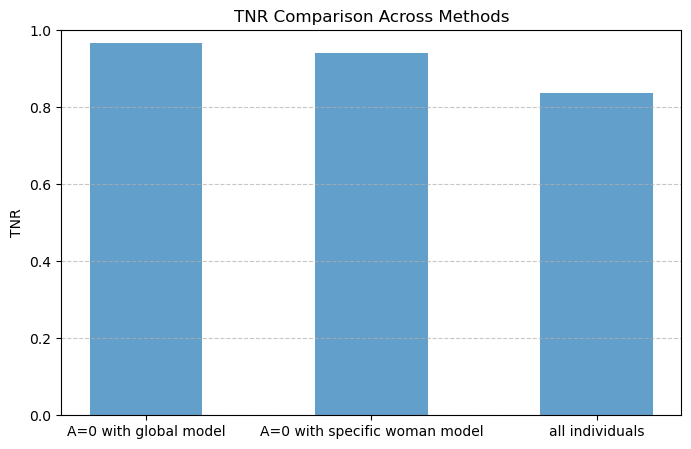

In [53]:
# Define the function to plot metrics
def plot_metrics(metrics_dict, labels):
    for metric, values in metrics_dict.items():
        plt.figure(figsize=(8, 5))
        plt.bar(labels, values, alpha=0.7, width=0.5)
        plt.title(f"{metric} Comparison Across Methods")
        plt.ylabel(metric)
        plt.ylim(0, 1)  # Metrics are proportions
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

# Example dictionary to hold metrics (for demonstration; replace these with actual computations)
metrics_example = {
    "Accuracy": [accuracy_female_fromall_LR, acc_female, acc],
    "TPR": [tpr_female_fromall_LR, tpr_female, tpr],
    "TNR": [tnr_female_fromall_LR, tnr_female, tnr]
}

labels_example = ["A=0 with global model", "A=0 with specific woman model", "all individuals"]

# Call the function with computed metrics
# Replace `metrics_example` and `labels_example` with your actual data
plot_metrics(metrics_example, labels_example)


In [52]:
#on veut voir si les femmes sont mal prédictes par le modele ou predites differemment ...
y_female_usingall_pred_LR=clf_LR.predict(X_female_test)
from sklearn.metrics import accuracy_score
from sklearn import metrics

accuracy_female_fromall_LR=accuracy_score(y_female_test.ravel(),y_female_usingall_pred_LR.ravel())
tpr_female_fromall_LR=np.sum((y_female_usingall_pred_LR.ravel()==1)*(y_female_test.ravel()==1)) / np.sum(y_female_usingall_pred_LR.ravel()==1)
tnr_female_fromall_LR=np.sum((y_female_usingall_pred_LR.ravel()==0)*(y_female_test.ravel()==0)) / np.sum(y_female_usingall_pred_LR.ravel()==0)

cm_female_fromall = metrics.confusion_matrix(y_female_test.ravel(),y_female_test_pred_LR.ravel(),labels=[0,1])

print("\nAccuracy =",accuracy_female_fromall_LR)
print("True positive rate =",tpr_female_fromall_LR)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
print("True negative rate =",tnr_female_fromall_LR)
print('\nConfusion matrix ([[TN,FP],[FN,TP]]) =')
print(cm_female_fromall)


Accuracy = 0.9041916167664671
True positive rate = 0.5508684863523573
True negative rate = 0.9669457910973998

Confusion matrix ([[TN,FP],[FN,TP]]) =
[[4643  107]
 [ 287  307]]


In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn import preprocessing





clf_LR = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_DT = DecisionTreeClassifier(max_depth=5, random_state=42)

clf_LR.fit(X_train, y_train.ravel())
clf_GB.fit(X_train, y_train.ravel())
clf_DT.fit(X_train, y_train.ravel())

# Predictions on the test set for models trained on all data
y_test_pred_LR = clf_LR.predict(X_test)
y_test_pred_GB = clf_GB.predict(X_test)
y_test_pred_DT = clf_DT.predict(X_test)

# Train models on male and female data subsets
#clf_male_GB = lgb.LGBMClassifier(random_state=42)
clf_female_GB = lgb.LGBMClassifier(random_state=42)
#clf_male_DT = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_female_DT = DecisionTreeClassifier(max_depth=5, random_state=42)

#clf_male_GB.fit(X_male_train, y_male_train.ravel())
clf_female_GB.fit(X_female_train, y_female_train.ravel())
#clf_male_DT.fit(X_male_train, y_male_train.ravel())
clf_female_DT.fit(X_female_train, y_female_train.ravel())

# Predictions for gender-specific models on male and female test sets
#y_male_test_pred_GB = clf_male_GB.predict(X_male_test)
y_female_test_pred_GB = clf_female_GB.predict(X_female_test)
#y_male_test_pred_DT = clf_male_DT.predict(X_male_test)
y_female_test_pred_DT = clf_female_DT.predict(X_female_test)


y_female_fromall_test_pred_GB=clf_GB.predict(X_female_test)
y_female_fromall_test_pred_DT=clf_DT.predict(X_female_test)

[LightGBM] [Info] Number of positive: 7839, number of negative: 24885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 32724, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239549 -> initscore=-1.155154
[LightGBM] [Info] Start training from score -1.155154
[LightGBM] [Info] Number of positive: 1175, number of negative: 9673
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 10848, number of used features: 32
[LightGBM] [Info] [bina

In [27]:
# Import necessary metric
from sklearn.metrics import accuracy_score, confusion_matrix

# Accuracy of models trained on all data, evaluated on female test set
accuracy_female_fromall_GB = accuracy_score(y_female_test, y_female_fromall_test_pred_GB) * 100
accuracy_female_fromall_DT = accuracy_score(y_female_test, y_female_fromall_test_pred_DT) * 100

# Accuracy of models trained on female-only data, evaluated on female test set
accuracy_female_GB = accuracy_score(y_female_test, y_female_test_pred_GB) * 100
accuracy_female_DT = accuracy_score(y_female_test, y_female_test_pred_DT) * 100

# Calculate percentages for each component in the confusion matrix
def calculate_confusion_percentages(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    true_negative = cm[0, 0] / total * 100
    false_positive = cm[0, 1] / total * 100
    false_negative = cm[1, 0] / total * 100
    true_positive = cm[1, 1] / total * 100
    return true_negative, false_positive, false_negative, true_positive

# Percentages for LightGBM (all data) on female test set
tn_GB_all, fp_GB_all, fn_GB_all, tp_GB_all = calculate_confusion_percentages(y_female_test, y_female_fromall_test_pred_GB)

# Percentages for LightGBM (female-only) on female test set
tn_GB_female, fp_GB_female, fn_GB_female, tp_GB_female = calculate_confusion_percentages(y_female_test, y_female_test_pred_GB)

# Percentages for Decision Tree (all data) on female test set
tn_DT_all, fp_DT_all, fn_DT_all, tp_DT_all = calculate_confusion_percentages(y_female_test, y_female_fromall_test_pred_DT)

# Percentages for Decision Tree (female-only) on female test set
tn_DT_female, fp_DT_female, fn_DT_female, tp_DT_female = calculate_confusion_percentages(y_female_test, y_female_test_pred_DT)

# Display results
print(f"Accuracy of LightGBM (all data) on female test set: {accuracy_female_fromall_GB:.2f}%")
print(f"True Negative: {tn_GB_all:.2f}%, False Positive: {fp_GB_all:.2f}%, False Negative: {fn_GB_all:.2f}%, True Positive: {tp_GB_all:.2f}%")

print(f"\nAccuracy of LightGBM (female-only) on female test set: {accuracy_female_GB:.2f}%")
print(f"True Negative: {tn_GB_female:.2f}%, False Positive: {fp_GB_female:.2f}%, False Negative: {fn_GB_female:.2f}%, True Positive: {tp_GB_female:.2f}%")

print(f"\nAccuracy of Decision Tree (all data) on female test set: {accuracy_female_fromall_DT:.2f}%")
print(f"True Negative: {tn_DT_all:.2f}%, False Positive: {fp_DT_all:.2f}%, False Negative: {fn_DT_all:.2f}%, True Positive: {tp_DT_all:.2f}%")

print(f"\nAccuracy of Decision Tree (female-only) on female test set: {accuracy_female_DT:.2f}%")
print(f"True Negative: {tn_DT_female:.2f}%, False Positive: {fp_DT_female:.2f}%, False Negative: {fn_DT_female:.2f}%, True Positive: {tp_DT_female:.2f}%")



Accuracy of LightGBM (all data) on female test set: 90.25%
True Negative: 87.48%, False Positive: 1.40%, False Negative: 8.35%, True Positive: 2.77%

Accuracy of LightGBM (female-only) on female test set: 92.07%
True Negative: 85.89%, False Positive: 2.99%, False Negative: 4.94%, True Positive: 6.18%

Accuracy of Decision Tree (all data) on female test set: 91.47%
True Negative: 86.45%, False Positive: 2.43%, False Negative: 6.10%, True Positive: 5.01%

Accuracy of Decision Tree (female-only) on female test set: 91.88%
True Negative: 86.36%, False Positive: 2.53%, False Negative: 5.60%, True Positive: 5.52%


In [28]:
accuracy_female_fromall_DT=accuracy_score(y_female_test.ravel(),y_female_fromall_test_pred_DT.ravel())
accuracy_female_fromall_GB=accuracy_score(y_female_test.ravel(),y_female_fromall_test_pred_GB.ravel())
tpr_female_DT=np.sum((y_female_fromall_test_pred_DT.ravel()==1)*(y_female_test.ravel()==1)) / np.sum(y_female_fromall_test_pred_DT.ravel()==1)
tnr_female_DT=np.sum((y_female_fromall_test_pred_DT.ravel()==0)*(y_female_test.ravel()==0)) / np.sum(y_female_fromall_test_pred_DT.ravel()==0)
tpr_female_GB=np.sum((y_female_fromall_test_pred_GB.ravel()==1)*(y_female_test.ravel()==1)) / np.sum(y_female_fromall_test_pred_GB.ravel()==1)
tnr_female_GB=np.sum((y_female_fromall_test_pred_GB.ravel()==0)*(y_female_test.ravel()==0)) / np.sum(y_female_fromall_test_pred_GB.ravel()==0)



In [29]:

# Display results
print("Results for Decision Tree (all data) on female test set:")
print(f"Accuracy: {accuracy_female_fromall_DT:.2f}%")
print(f"True Positive Rate (TPR): {tpr_female_DT:.2f}%")
print(f"True Negative Rate (TNR): {tnr_female_DT:.2f}%")

print("\nResults for LightGBM (all data) on female test set:")
print(f"Accuracy: {accuracy_female_fromall_GB:.2f}%")
print(f"True Positive Rate (TPR): {tpr_female_GB:.2f}%")
print(f"True Negative Rate (TNR): {tnr_female_GB:.2f}%")

Results for Decision Tree (all data) on female test set:
Accuracy: 0.91%
True Positive Rate (TPR): 0.67%
True Negative Rate (TNR): 0.93%

Results for LightGBM (all data) on female test set:
Accuracy: 0.90%
True Positive Rate (TPR): 0.66%
True Negative Rate (TNR): 0.91%


In [30]:

# Find indices of female data points in the original test set
female_indices_in_test = data_ohe.loc[X_test_NoScaling.index, 'Sex'] == 0

# Performance evaluation for each model on specific test sets
print("Logistic Regression (all data) accuracy on all test data:", accuracy_score(y_test, y_test_pred_LR))
print("LightGBM (all data) accuracy on all test data:", accuracy_score(y_test, y_test_pred_GB))
print("Decision Tree (all data) accuracy on all test data:", accuracy_score(y_test, y_test_pred_DT))

# Accuracy on female subset from the full test data predictions
print("LightGBM (all data) accuracy on female test data:", accuracy_score(y_female_test, y_test_pred_GB[female_indices_in_test]))
print("Decision Tree (all data) accuracy on female test data:", accuracy_score(y_female_test, y_test_pred_DT[female_indices_in_test]))

# Gender-specific models on their respective test sets
print("LightGBM (female-only) accuracy on female test data:", accuracy_score(y_female_test, y_female_test_pred_GB))
print("Decision Tree (female-only) accuracy on female test data:", accuracy_score(y_female_test, y_female_test_pred_DT))

print("LightGBM (male-only) accuracy on male test data:", accuracy_score(y_male_test, y_male_test_pred_GB))
print("Decision Tree (male-only) accuracy on male test data:", accuracy_score(y_male_test, y_male_test_pred_DT))

print("Done")


AttributeError: 'numpy.ndarray' object has no attribute 'index'

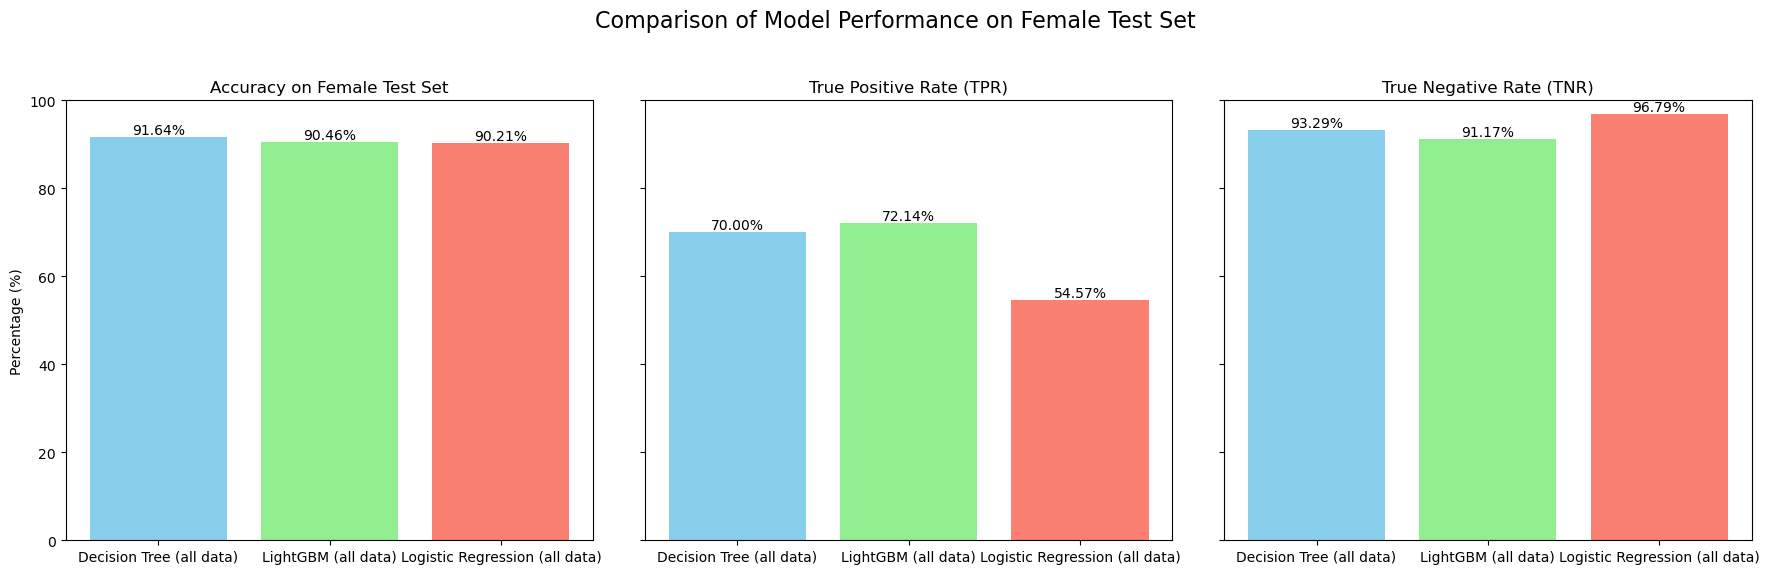

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the calculations
models = ['Decision Tree (all data)', 'LightGBM (all data)', 'Logistic Regression (all data)']
accuracy_scores = [accuracy_female_fromall_DT*100, accuracy_female_fromall_GB*100, accuracy_female_fromall_LR*100]
tpr_scores = [tpr_female_DT*100, tpr_female_GB*100, tpr_female_LR*100]
tnr_scores = [tnr_female_DT*100, tnr_female_GB*100, tnr_female_LR*100]

# Create a figure and axes for the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Bar chart for Accuracy
axes[0].bar(models, accuracy_scores, color=['skyblue', 'lightgreen', 'salmon'])
axes[0].set_title('Accuracy on Female Test Set')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_ylim(0, 100)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f%%')

# Bar chart for TPR
axes[1].bar(models, tpr_scores, color=['skyblue', 'lightgreen', 'salmon'])
axes[1].set_title('True Positive Rate (TPR)')
axes[1].set_ylim(0, 100)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f%%')

# Bar chart for TNR
axes[2].bar(models, tnr_scores, color=['skyblue', 'lightgreen', 'salmon'])
axes[2].set_title('True Negative Rate (TNR)')
axes[2].set_ylim(0, 100)
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%.2f%%')

# Add overall title and show plot
fig.suptitle('Comparison of Model Performance on Female Test Set', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### 2.3 Arbre de décisions 

Nous entrainons maintenant un arbre de décisions (<i>Decsion tree</i>), qui présente l'intérêt d'être facilement interprétable.


In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT.fit(X_train,y_train.ravel())

y_test_pred_DT = clf_DT.predict(X_test)

#*** Uncomment the three raws below to see the decision rules ***
#from sklearn import tree
#dot_data = tree.export_graphviz(DTC_clf)
#print(dot_data)

Voyons maintenant la précision des prévisions :

In [ ]:
acc=accuracy_score(y_test.ravel(),y_test_pred_DT.ravel())
tpr=np.sum((y_test_pred_DT.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_test_pred_DT.ravel()==1)
tnr=np.sum((y_test_pred_DT.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_test_pred_DT.ravel()==0)

cm = metrics.confusion_matrix(y_test.ravel(),y_test_pred_DT.ravel(),labels=[0,1])

print("\nAccuracy =",acc)
print("True positive rate =",tpr)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
print("True negative rate =",tnr)
print('\nConfusion matrix ([[TN,FP],[FN,TP]]) =')
print(cm)


Accuracy = 0.8476237746618687
True positive rate = 0.7347150259067358
True negative rate = 0.8723436436512138

Confusion matrix ([[TN,FP],[FN,TP]]) =
[[11535   768]
 [ 1688  2127]]


Il s'agit du meilleur résultat moyen jusqu'à présent. Remarquez cependant que si les prédictions sont clairement les meilleures pour les observations avec Y=0, elles sont clairement médiocres pour Y=1, qui contient environ 24% des observations. Il y a même plus de faux positifs que de vrais positifs.


### 2.4 Gradient Boosting

Nous entrainons maintenant un classifieur <i>Gradient Boosting</i> et testons son efficacité.

In [ ]:

import lightgbm as lgb

clf_GB = lgb.LGBMClassifier(random_state=42)
clf_GB.fit(X_train, y_train.ravel())

y_test_pred_GB = clf_GB.predict(X_test)

In [ ]:
acc=accuracy_score(y_test.ravel(),y_test_pred_GB.ravel())
tpr=np.sum((y_test_pred_GB.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_test_pred_GB.ravel()==1)
tnr=np.sum((y_test_pred_GB.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_test_pred_GB.ravel()==0)

cm = metrics.confusion_matrix(y_test.ravel(),y_test_pred_GB.ravel(),labels=[0,1])

print("\nAccuracy =",acc)
print("True positive rate =",tpr)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
print("True negative rate =",tnr)
print('\nConfusion matrix ([[TN,FP],[FN,TP]]) =')
print(cm)


Accuracy = 0.8574885221491501
True positive rate = 0.7431133888532991
True negative rate = 0.8849646044936904

Confusion matrix ([[TN,FP],[FN,TP]]) =
[[11501   802]
 [ 1495  2320]]


***
## 3 Mesurer les Biais
***

### 3.1 Définition


Différentes définitions du biais, soit dans les données d'apprentissage, soit dans les décisions d'un algorithme, ont été proposées dans la littérature statistique. Parmi celles-ci, nous considérerons ce que l'on appelle la parité démographique (demographic parity / disparate impact).

Considérons les notations suivantes :
-$Y$  est la variable à prévoir ou à expliquer. Nous considérons ici des variables binaires où $Y=1$ correspond à une décision positive (c'est-à-dire un revenu élevé) tandis que $Y=0$ correspond à un revenu faible.
- $g(X)=\hat{Y}$ est la prédiction donnée par l'algorithme. Il peut s'agir d'un score ou d'une variable binaire, les petits scores conduisant à la prévision $\hat{Y}=0$ tandis que les scores plus élevés entraînent $\hat{Y}=1$.
- $S$ est la variable qui divise la population en groupes susceptibles d'être traités différemment, ce qui induit un biais. D'un point de vue juridique ou moral, $S$ est une variable sensible qui ne doit pas influencer la décision, sous peine de conduire à une décision discriminatoire. Nous considérons ci-après le cas où $S=1$ représente la majorité tandis que $S=0$ représente la minorité susceptible de faire l'objet d'une discrimination (homme contre femme ou caucasien contre non caucasien).


Une façon de mesurer cette possibilité est l'impact disparate [Biddle D. 2005]. Nous allons d'abord considérer l'impact disparate général qui mesure le biais déjà existant dans l'ensemble de données de la manière suivante.

$$ DI = \frac{\mathbb{P}(Y=1 | S=0)}{\mathbb{P}(Y=1 | S=1)}$$

Il peut être simplement estimé avec : 

$$ \frac{n_{1,0}}{(n_{0,0}+n_{1,0})}  /  \frac{n_{1,1}}{(n_{0,1}+n_{1,1})}$$

où $n_{i,j}$ est le nombre d'observations pour lesquelles $Y=i$ et $S=j$. Cette notion de DI peut être étendue au résultat d'un algorithme en remplaçant la vraie variable $Y$ by $g(X)=\hat{Y}$. 

$$ DI = \frac{\mathbb{P}(\hat{Y}=1 | S=0)}{\mathbb{P}(\hat{Y}=1 | S=1)}$$

Cela mesure le biais de la prédiction et quantifie ainsi le risque d'une discrimination.

En fait, l'équité induite par le critère de parité démographique signifie que la décision ne doit pas dépendre de la variable sensible (ou protégée). Par conséquent, les variables aléatoires $\hat{Y}$ 
doivent être indépendantes de $S$. L'impact disparate $DI(g)$ doit donc être proche de $1$ pour une décision totalement équitable, ou du moins ne doit pas être inférieur à l'impact disparate général $DI$. Plus l'impact disparate est faible, plus la discrimination à l'égard du groupe minoritaire est importante.

Il convient de noter que d'autres mesures de discrimination peuvent être utilisées et sont décrites dans [Hardt et al. 2016].



### 3.2 Estimation de la parité statistique (disparate impact)

#### Function cptDI

Il est facile de fournir une estimation du $DI$ en considérant la version empirique du critère intégré. Nous fournissons une fonction Python pour la calculer, qui renvoie le $DI$ et prend comme entrée

- la variable $S$ : Il s'agit d'un vecteur np.array avec deux valeurs possibles, la première étant une minorité (S[i]=0) tandis que la seconde est une majorité (S[i]=1).
- La vraie cible $Y$ ou sa prévision $g(X)=\hat{Y}$ : Il s'agit à nouveau d'un vecteur np.array avec deux valeurs possibles, d'abord la décision négative (Y[i]=0) et ensuite la décision positive (Y[i]=1).


In [ ]:
from FinalBiasAnalysis_compBWAF import cptDI


### 3.3 Biais dans les données Adult

#### Parité statistique (Disparate Impact) par rapport à la variable Sex


In [ ]:
S=X[:,X_col_names.index('Sex')].ravel()

DI=cptDI(S,y.ravel())

print("Disparate Impact="+str(DI))


Disparate Impact=0.35965526258003366


#### Parité statistique (Disparate Impact) par rapport à la variable Ethnic Origin


In [ ]:
S=X[:,X_col_names.index('OrigEthn')].ravel()

DI=cptDI(S,y.ravel())

print("Disparate Impact="+str(DI))


Disparate Impact=0.6005915505110953


Conclusion : la DI met en évidence le biais déjà présent dans l'ensemble de données original. Le biais est plus important lorsque l'on tient compte de la différence entre les sexes.

### 3.4 Biais dans les algorithmes d'Apprentissage Automatique

Nous calculons maintenant la parité statistique à l'aide des modèles formés précédemment : régression logistique, arbre et forêt aléatoire. Nous le faisons d'abord pour le sexe, puis pour l'origine ethnique.


#### Variable Sex




In [ ]:
S=X_test_NoScaling[:,X_col_names.index('Sex')].ravel()

DI=cptDI(S,y_test.ravel())
print('DI y_test =',DI)


y_test_pred_LR = clf_LR.predict(X_test)
DI=cptDI(S,y_test_pred_LR.ravel()) #Logistic Regression
print('DI y_test_pred_LR =',DI)

y_test_pred_DT = clf_DT.predict(X_test)
DI=cptDI(S,y_test_pred_DT.ravel()) #Decision tree
print('DI y_test_pred_DT =',DI)

y_test_pred_GB = clf_GB.predict(X_test)
DI=cptDI(S,y_test_pred_GB.ravel()) #Gradient boosting
print('DI y_test_pred_GB =',DI)

DI y_test = 0.3891183428482053
DI y_test_pred_LR = 0.24966291195529947
DI y_test_pred_DT = 0.29667931437062206
DI y_test_pred_GB = 0.29886916831536864


La parité statistique en ce qui concerne la variable <i>Sex</i> est clairement inférieur à 0,8 avec le vrai $y$. Le message clé ici est cependant que cet impact disparate s'aggrave même en utilisant tous les prédicteurs entraînés. 


#### Variable OrigEthn


In [ ]:
S=X_test_NoScaling[:,X_col_names.index('OrigEthn')].ravel()

DI=cptDI(S,y_test.ravel())
print('DI y_test =',DI)

y_test_pred_LR = clf_LR.predict(X_test)
DI=cptDI(S,y_test_pred_LR.ravel()) #Logistic Regression
print('DI y_test_pred_LR =',DI)

y_test_pred_DT = clf_DT.predict(X_test)
DI=cptDI(S,y_test_pred_DT.ravel()) #Decision tree
print('DI y_test_pred_DT =',DI)

y_test_pred_GB = clf_GB.predict(X_test)
DI=cptDI(S,y_test_pred_GB.ravel()) #Gradient boosting
print('DI y_test_pred_GB =',DI)

DI y_test = 0.6014520424667694
DI y_test_pred_LR = 0.5063393778564056
DI y_test_pred_DT = 0.6083032525725066
DI y_test_pred_GB = 0.5112120999027225


Comme pour la variable <i>Sex</i>, la parité statistique par rapport à l'origine ethnique est inférieure à $0,8$ en utilisant le vrai $y$. Cette fois, elle est restée globalement stable en utilisant les modèles d'apprentissage automatique testés. **Il faut faire attention, lors de l'apprentissage des règles de décision, au fait qu'elles peuvent aggraver la discrimination existante dans la base de données.**

### 3.5  Tenir compte des incertitudes sur l'échantillonnage des données avec les K-folds

Comme le soulignent Friedler et al. (2019), il existe une forte variabilité lors du calcul du DI pour différents sous-échantillons de données.

Le code suivant permet de valider de manière croisée de tels résultats en utilisant 10 réplications de différents échantillons d'apprentissage et de test sur lesquels les trois algorithmes ont été entraînés : logistique linéaire, arbre de décision et forêt aléatoire. La DI est ensuite calculée sur l'échantillon de test.



In [ ]:

from FinalBiasAnalysis_compBWAF import Make_Kfold_boxplots


Nous sommes maintenant prêts à comparer les méthodes avec OrigEthn et Sex comme variable sensible.

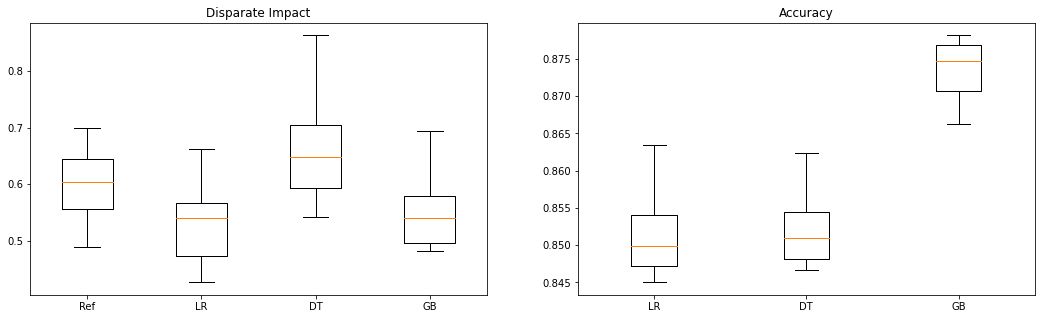

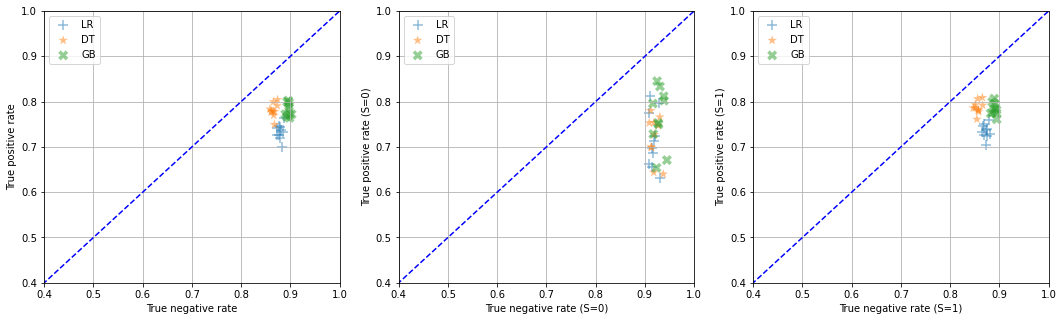

Average rates LR:
 -> True positive (all/S=0/S=1): 0.73 0.72 0.74
 -> True negative (all/S=0/S=1): 0.88 0.92 0.87
Average rates DT:
 -> True positive (all/S=0/S=1): 0.78 0.72 0.79
 -> True negative (all/S=0/S=1): 0.87 0.92 0.86
Average rates GB:
 -> True positive (all/S=0/S=1): 0.78 0.76 0.78
 -> True negative (all/S=0/S=1): 0.9 0.93 0.89


In [ ]:
#print("++++++++++++++++++++++++++++++++++++++++++++++++++") 
#print("+          SENSITIVE VARIABLE = OrigEthn         +")
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")

S=X[:,X_col_names.index('OrigEthn')].ravel()


clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_DT =DecisionTreeClassifier(max_depth=5)
clf_GB = lgb.LGBMClassifier(random_state=42)

list_classifiers=[clf_LR,clf_DT,clf_GB]
list_classifierNames=['LR', 'DT', 'GB']
nsplits=10


X_scaled=sk.preprocessing.scale(X)

PreFigNam='StandardOrigEthn'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X_scaled,y,nsplits,PrefixFigNames=PreFigNam)

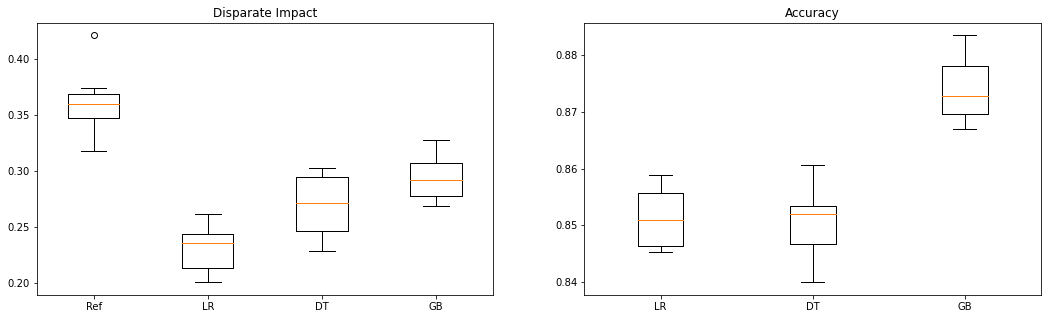

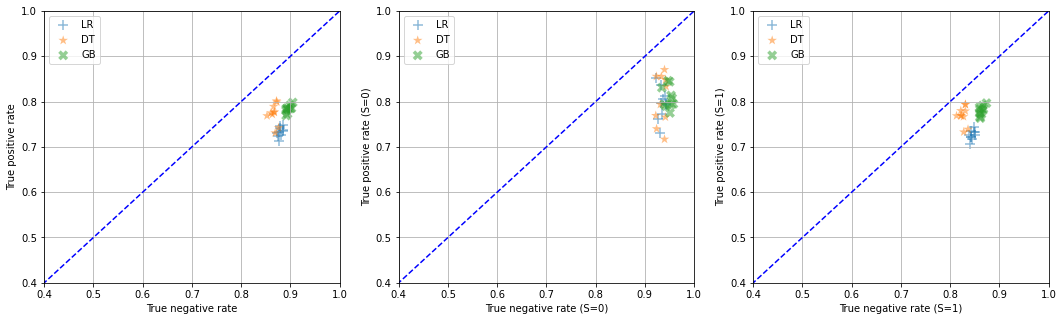

Average rates LR:
 -> True positive (all/S=0/S=1): 0.73 0.8 0.73
 -> True negative (all/S=0/S=1): 0.88 0.93 0.85
Average rates DT:
 -> True positive (all/S=0/S=1): 0.77 0.8 0.77
 -> True negative (all/S=0/S=1): 0.87 0.93 0.83
Average rates GB:
 -> True positive (all/S=0/S=1): 0.78 0.81 0.78
 -> True negative (all/S=0/S=1): 0.9 0.95 0.86


In [ ]:
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")
#print("+            SENSITIVE VARIABLE = Sex            +")
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")

S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_DT =DecisionTreeClassifier(max_depth=5)
clf_GB = lgb.LGBMClassifier(random_state=42)

list_classifiers=[clf_LR,clf_DT,clf_GB]
list_classifierNames=['LR', 'DT', 'GB']
nsplits=10


X_scaled=sk.preprocessing.scale(X)

PreFigNam='StandardSex'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X_scaled,y,nsplits,printAverageRes=False,PrefixFigNames=PreFigNam)


Comme prévu, la précision dépend de l'algorithme. Mais il en va de même pour la DI. Cette dernière n'est pas corrélée à l'efficacité de l'algorithme. 


## 4 Correction de modèles discriminants avec des approches naïves

**Nous allons maintenant nous concentrer sur la variable <i>Sex</i>**, car les prédictions de tous les algorithmes d'apprentissage automatique testés renforcent les discriminations par rapport à cette variable. Dans la suite, nous testerons différentes approches naïves pour tenter de rendre les prédictions plus équitables. 


### 4.1 Que se passerait-il s'il y avait autant de Femmes et d'Hommes dans le jeu d'apprentissage ?

Une première explication intuitive de l'augmentation des décisions injustes est qu'il y a plus de mâles que de femelles dans l'ensemble d'apprentissage, de sorte que les stratégies d'apprentissage automatique conduisent à des prédictions plus efficaces sur les mâles. Nous verrons ci-dessous que ce phénomène apparaît comme mineur en exécutant à nouveau les calculs sur des données qui sont bien équilibrées entre le nombre d'hommes et de femmes.



16192 32650


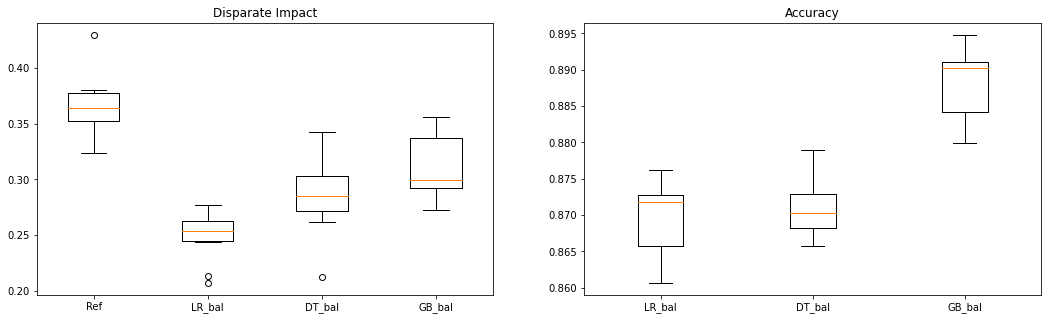

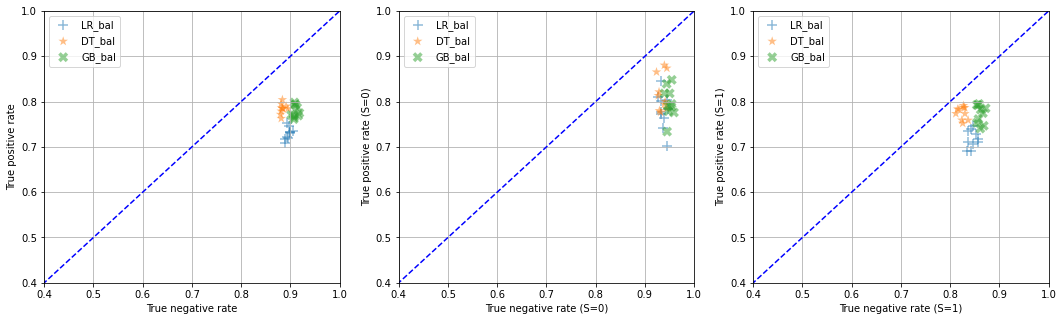

Average rates LR_bal:
 -> True positive (all/S=0/S=1): 0.73 0.78 0.72
 -> True negative (all/S=0/S=1): 0.9 0.94 0.84
Average rates DT_bal:
 -> True positive (all/S=0/S=1): 0.78 0.82 0.77
 -> True negative (all/S=0/S=1): 0.88 0.94 0.82
Average rates GB_bal:
 -> True positive (all/S=0/S=1): 0.78 0.8 0.77
 -> True negative (all/S=0/S=1): 0.91 0.95 0.86


In [ ]:
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")
#print("+    SENSITIVE VARIABLE = Sex  / balanced M/F    +")
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")

S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_DT =DecisionTreeClassifier(max_depth=5)
clf_GB = lgb.LGBMClassifier(random_state=42)

list_classifiers=[clf_LR,clf_DT,clf_GB]
list_classifierNames=['LR_bal', 'DT_bal', 'GB_bal']
nsplits=10

nb_S0=np.sum(1*(S==0.))
nb_S1=np.sum(1*(S==1.))

print(nb_S0,nb_S1)
X_balanced=np.zeros((2*nb_S0,37))
y_balanced=np.zeros((2*nb_S0,1))
S_balanced=np.zeros((2*nb_S0))

tot_copied_S1=0
tot_copied=0
for i in range(nb_S0+nb_S1):
    if S[i]==0.:
        X_balanced[tot_copied,:]=X[i,:]
        y_balanced[tot_copied,:]=y[i,:]
        S_balanced[tot_copied]=S[i]
        tot_copied+=1
    else:
        if tot_copied_S1<nb_S0:
            X_balanced[tot_copied,:]=X[i,:]
            y_balanced[tot_copied,:]=y[i,:]
            S_balanced[tot_copied]=S[i]
            tot_copied+=1
            tot_copied_S1+=1
        

PreFigNam='BalancedSex'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S_balanced,X_balanced,y_balanced,nsplits,printAverageRes=False,PrefixFigNames=PreFigNam)


Nous pouvons remarquer que la précision de la prédiction et les DI ont été légèrement améliorés par rapport à ce que nous avons obtenu en utilisant l'ensemble de données original. Les phénomènes indésirables que nous avons observés sont cependant toujours clairement présents dans ces résultats.

### 4.2 Que se passe-t-il si la variable sensible est supprimée ?

Nous entraînons les algorithmes précédents sur des ensembles de données d'apprentissage pour lesquels nous supprimons la variable sensible. Cela pourrait réduire la discrimination étant donné que les règles de décision ont utilisé cette variable jusqu'à présent.




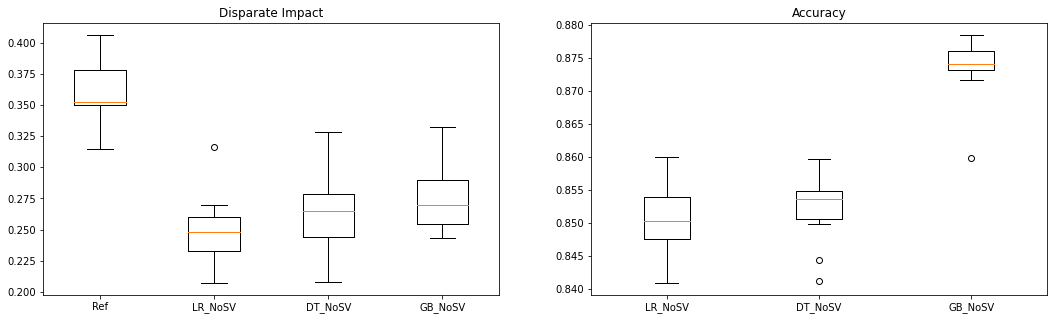

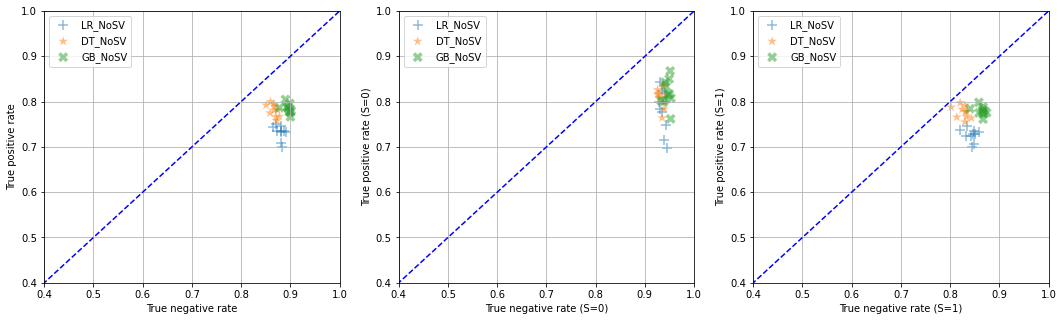

Average rates LR_NoSV:
 -> True positive (all/S=0/S=1): 0.73 0.78 0.73
 -> True negative (all/S=0/S=1): 0.88 0.94 0.84
Average rates DT_NoSV:
 -> True positive (all/S=0/S=1): 0.78 0.81 0.78
 -> True negative (all/S=0/S=1): 0.87 0.93 0.83
Average rates GB_NoSV:
 -> True positive (all/S=0/S=1): 0.78 0.82 0.78
 -> True negative (all/S=0/S=1): 0.9 0.95 0.86
Average D.I. (Average Acc):
LR_NoSV: 0.25(0.851)
DT_NoSV: 0.268(0.852)
GB_NoSV: 0.276(0.873)


In [ ]:
#1) prepare the data and parameters
X_wo_SV=X.copy()
X_wo_SV=np.delete(X_wo_SV,X_col_names.index('Sex'),axis=1)
S=X[:,X_col_names.index('Sex')]
nsplits=10

#2) re-run the K-fold validation with X
#clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
#clf_DT =DecisionTreeClassifier(max_depth=5)
#clf_GB = lgb.LGBMClassifier(random_state=42)
#
#list_classifiers=[clf_LR,clf_DT,clf_GB]
#list_classifierNames=['LR', 'DT', 'GB']
#
#Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,printAverageRes=True)

#3) Remove the Sensitive Variable (SV) and run the K-fold validation without the sensitive variable
clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_DT =DecisionTreeClassifier(max_depth=5)
clf_GB = lgb.LGBMClassifier(random_state=42)

list_classifiers=[clf_LR,clf_DT,clf_GB]
list_classifierNames=['LR_NoSV', 'DT_NoSV', 'GB_NoSV']

PreFigNam='NoSV'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X_wo_SV,y,nsplits,printAverageRes=True,PrefixFigNames=PreFigNam)


Il est surprenant de constater que les précisions et les DI **sont restés pratiquement inchangés lorsque l'on a supprimé la variable Sex** des données d'entrée X. Ainsi, la suppression d'une variable sensible n'a pas nécessairement l'effet escompté puisqu'elle peut être fortement corrélée à d'autres variables. Ici, la variable Sex est incluse dans les corrélations avec toutes les autres. Le déterminisme social est plus fort que la présence de la variable sensible, de sorte que les algorithmes de classification ne sont pas automatiquement affectés par la suppression de la variable.


### 4.3 Procédures de test pour les prédictions injustes

Les procédures de test sont souvent utilisées comme preuve juridique de la discrimination. Elles consistent à créer un individu artificiel qui partage les mêmes caractéristiques mais dont la variable protégée est différente. Ces procédures tentent de mettre en évidence la discrimination individuelle. Elles existent depuis longtemps (1939, voir par exemple https://fr.wikipedia.org/wiki/Test_de_discrimination). La justice les considère comme une preuve de traitement partial (https://www.juritravail.com/discrimination-physique/embauche/ph-alternative-A-1.html) depuis 2016, même si le processus de test lui-même a été qualifié d'inéquitable.

En outre, le testing en tant que test de discrimination est aujourd'hui une méthode couramment utilisée en France pour évaluer l'équité dans le cadre des études sociologiques de l'<a href="http://www.observatoiredesdiscriminations.fr/testing">Observatoire des discriminations</a>, du laboratoire TEPP L'<a href="http://www.tepp.eu/doc/users/268/bib/banque-et-assurance_9025.pdf">Horty et al. (2017)</a>, ou des études gouvernementales <a href="http://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/etudes-et-syntheses/dares-analyses-dares-indicateurs-dares-resultats/testing">DARES</a> du ministère français du travail <a href="http://www.ismcorum.org/">ISM Corum</a>. Certains secteurs d'activité sont labellisés à l'aide de ces <a href="http://www.ismcorum.org/le-testing-d-entreprise-%E2%80%93-temoignages-d-adecco-casino-lvmh-michael-page-M22-R22-A443.html">tests</a>. Un <a href="http://www.observatoiredesdiscriminations.fr/diagnostics-qualite">audit</a> de la qualité des méthodes de recrutement est proposé tandis que <a href="https://www.novethic.fr/lexique/detail/testing.html">Novethic</a> propose des formations à l'éthique.

Pourtant, comme nous le montrerons, les tests ne garantissent pas l'équité. Pire, une astuce facile pour contourner les tests consiste à modifier n'importe quel algorithme de la manière suivante. Pour chaque candidat, le résultat sera la meilleure décision de l'algorithme exécutée pour deux cas : la caractéristique réelle du candidat et le candidat virtuel avec exactement les mêmes caractéristiques, mais avec une valeur opposée pour la variable protégée $S$.


In [ ]:

from FinalBiasAnalysis_compBWAF import Clf_with_BestPredForTheSV


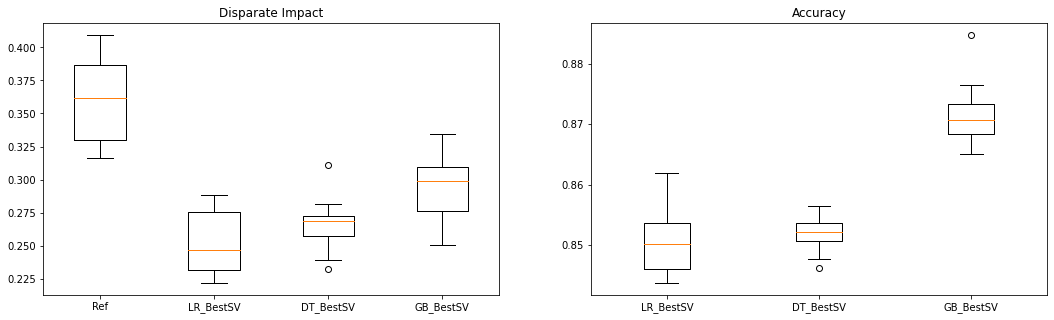

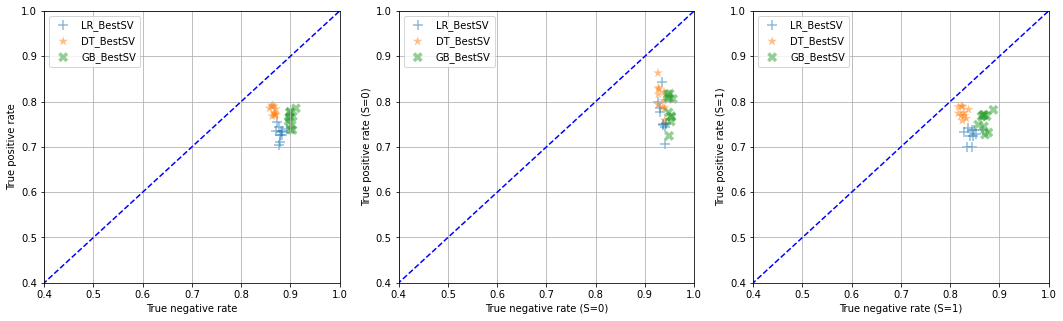

Average rates LR_BestSV:
 -> True positive (all/S=0/S=1): 0.73 0.77 0.73
 -> True negative (all/S=0/S=1): 0.88 0.94 0.84
Average rates DT_BestSV:
 -> True positive (all/S=0/S=1): 0.78 0.81 0.78
 -> True negative (all/S=0/S=1): 0.87 0.93 0.83
Average rates GB_BestSV:
 -> True positive (all/S=0/S=1): 0.76 0.78 0.76
 -> True negative (all/S=0/S=1): 0.9 0.95 0.87
Average D.I. (Average Acc):
LR_BestSV: 0.252(0.851)
DT_BestSV: 0.266(0.852)
GB_BestSV: 0.294(0.872)


In [ ]:
S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_LR_BSV=Clf_with_BestPredForTheSV(clf_LR,X_col_names.index('Sex'))
    
clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT_BSV=Clf_with_BestPredForTheSV(clf_DT,X_col_names.index('Sex'))
    
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_GB_BSV=Clf_with_BestPredForTheSV(clf_GB,X_col_names.index('Sex'))


#list_classifiers=[clf_LR,clf_LR_BSV,clf_DT,clf_DT_BSV,clf_GB,clf_GB_BSV]
#list_classifierNames=['LR', 'LR_BestSV', 'DT', 'DT_BestSV', 'GB', 'GB_BestSV']

list_classifiers=[clf_LR_BSV,clf_DT_BSV,clf_GB_BSV]
list_classifierNames=['LR_BestSV', 'DT_BestSV',  'GB_BestSV']

nsplits=10

PreFigNam='BestSV'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,printAverageRes=True,PrefixFigNames=PreFigNam)


L'erreur de classification n'évolue pas trop. Cela semble avoir un effet négligeable. L'effet de la variable Sex sur les prédictions est alors définitivement capturé dans d'autres variables. L'élimination de l'effet de la variable sensible nécessite donc des traitements plus poussés.



### 4.4 Modèle spécifique pour chaque groupe de la variable sensible

Une stratégie légèrement différente consiste à entraîner le même modèle de prédiction avec des paramètres différents pour chaque classe de la variable sensible. 

In [ ]:

from FinalBiasAnalysis_compBWAF import Clf_with_ClassSpecDecRules


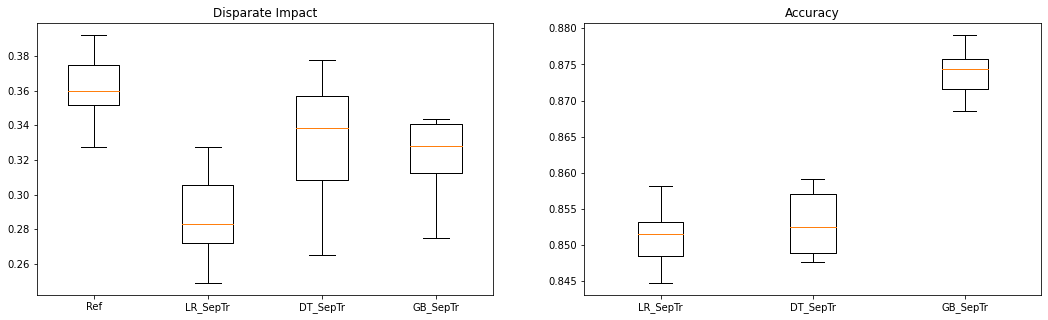

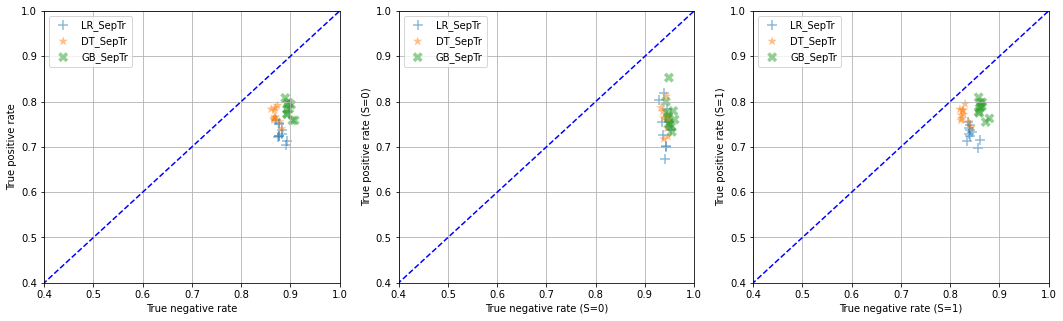

Average rates LR_SepTr:
 -> True positive (all/S=0/S=1): 0.73 0.75 0.73
 -> True negative (all/S=0/S=1): 0.88 0.94 0.84
Average rates DT_SepTr:
 -> True positive (all/S=0/S=1): 0.77 0.76 0.77
 -> True negative (all/S=0/S=1): 0.87 0.94 0.83
Average rates GB_SepTr:
 -> True positive (all/S=0/S=1): 0.78 0.77 0.78
 -> True negative (all/S=0/S=1): 0.9 0.95 0.86


In [ ]:
S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_LR_CS=Clf_with_ClassSpecDecRules(clf_LR,X_col_names.index('Sex'),ReturnBestPred=False)
    
clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT_CS=Clf_with_ClassSpecDecRules(clf_DT,X_col_names.index('Sex'),ReturnBestPred=False)
    
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_GB_CS=Clf_with_ClassSpecDecRules(clf_GB,X_col_names.index('Sex'),ReturnBestPred=False)


#list_classifiers=[clf_LR,clf_LR_CS,clf_DT,clf_DT_CS,clf_GB,clf_GB_CS]
#list_classifierNames=['LR', 'LR_SepTr', 'DT', 'DT_SepTr', 'GB', 'GB_SepTr']

list_classifiers=[clf_LR_CS,clf_DT_CS,clf_GB_CS]
list_classifierNames=['LR_SepTr', 'DT_SepTr', 'GB_SepTr']

nsplits=10

PreFigNam='SepTr'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,PrefixFigNames=PreFigNam)


Séparer les modèles en fonction des groupes sensibles ou non apparait ici comme une bonne solution. Dans tous les cas, il a amélioré l'impact disparate pour des précisions de prédiction relativement stables. Notons que les améliorations sont plus spectaculaires pour les modèles de base *Régression logistique* et *Arbre de décision* que pour le modèle *Gradient Boosting*. Ce dernier modèle est en effet particulièrement efficace pour capturer les relations fines d'ordre élevé entre les variables, ce qui donne moins d'influence à la forte non-linéarité générée lors de la division du modèle M.L. en deux modèles M.L. spécifiques à une classe.


Maintenant, rendre le DI au moins similaire ou même meilleur que celui observé sur les données de référence nécessite des méthodes plus avancées. 


### 4.5 Seuils spécifiques pour chaque classe de la variable sensible 

Nous testons maintenant une stratégie alternative à la précédente, où un seul classificateur est entraîné pour toutes les données mais où le seuil utilisé pour la probabilité de sortie n'est pas nécessairement 0.5, mais est adapté pour éviter les discriminations. 

En pratique ici :
- Nous gardons un sueil de 0.5 pour les observations du groupe S=1. 
- Si un D.I. est sous 0.8, nous adaptons le seuil de selection des Y=1, de manière à ce que le D.I. soit proche de 0.8.


In [ ]:

from FinalBiasAnalysis_compBWAF import Clf_with_AdaptiveThreshForS0


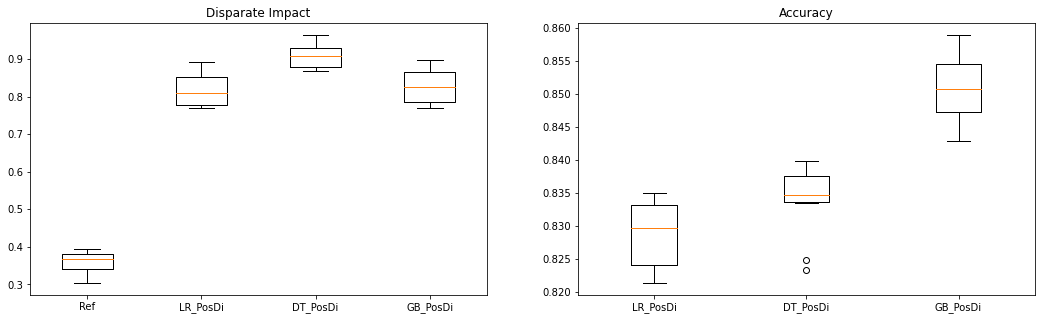

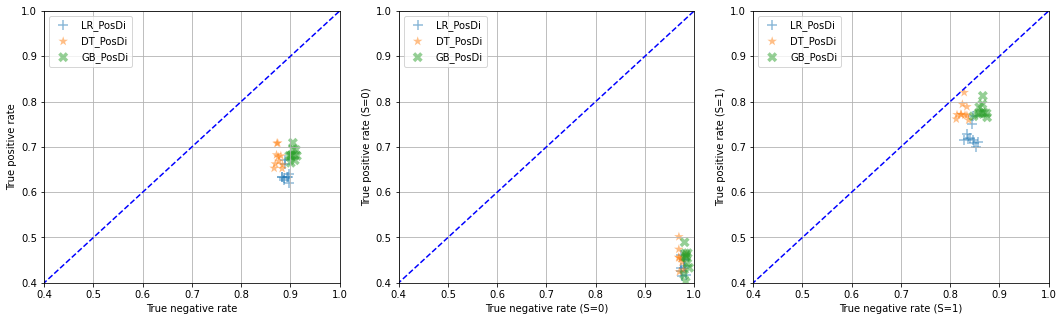

Average rates LR_PosDi:
 -> True positive (all/S=0/S=1): 0.64 0.43 0.72
 -> True negative (all/S=0/S=1): 0.89 0.98 0.84
Average rates DT_PosDi:
 -> True positive (all/S=0/S=1): 0.68 0.45 0.78
 -> True negative (all/S=0/S=1): 0.88 0.97 0.83
Average rates GB_PosDi:
 -> True positive (all/S=0/S=1): 0.68 0.45 0.78
 -> True negative (all/S=0/S=1): 0.91 0.98 0.86
Average confusion matrices:
LR_PosDi: 
[[0.6726383  0.08807993]
 [0.08320708 0.15607469]]

DT_PosDi: 
[[0.69305106 0.06766717]
 [0.09856271 0.14071905]]

GB_PosDi: 
[[0.68308014 0.0776381 ]
 [0.07141395 0.16786782]]



In [ ]:
S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_LR_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_LR,X_col_names.index('Sex'))
    
clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_DT,X_col_names.index('Sex'))
    
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_GB_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_GB,X_col_names.index('Sex'))


#list_classifiers=[clf_LR,clf_LR_AdapThresh,clf_DT,clf_DT_AdapThresh,clf_GB,clf_GB_AdapThresh]
#list_classifierNames=['LR', 'LR_PosDi', 'DT', 'DT_PosDi', 'GB', 'GB_PosDi']

list_classifiers=[clf_LR_AdapThresh,clf_DT_AdapThresh,clf_GB_AdapThresh]
list_classifierNames=[ 'LR_PosDi',  'DT_PosDi',  'GB_PosDi']

nsplits=10

PreFigNam='PosDi'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,printAverageConfusionMatrices=True,PrefixFigNames=PreFigNam)


En changeant les seuils avec lesquels $Y=1$ est prédit dans le groupe $S=0$, nous avons pu rendre le D.I. encore meilleur que celui observé dans les données originales. Remarquons que dans tous les cas, le changement de seuil a cependant diminué la précision de la prédiction.

Pour étudier cet effet en détail, nous avons représenté les matrices de confusion moyennes obtenues dans chaque groupe, où les taux représentés sont :

$$
\left(
\begin{array}{cc}
True  Negatives &False  Positives\\
False  Negatives &True  Positives\\
\end{array}
\right)
$$

En moyenne, le nombre de fausses prédictions négatives a diminué d'environ $13\%$ et le nombre de fausses prédictions positives a augmenté d'environ $76\%$. L'augmentation des prédictions faussement positives est alors particulièrement élevée compte tenu du fait que le seuil a été appliqué sur approximativement 33% des observations (celles avec $S=0$).


## 5 Résumé

Pour résumer cette section, voici un aperçu de tous les impacts disparates obtenus dans cette section. En plus des résultats déjà présentés ci-dessus, nous avons également testé la méthode de la section 4.4 avec des seuils modifiés pour obtenir un DI légèrement supérieur à celui observé dans les données, et pas seulement un DI proche de 0,8. Cela permet d'évaluer cette méthode avec des modifications raisonnables du seuil.


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


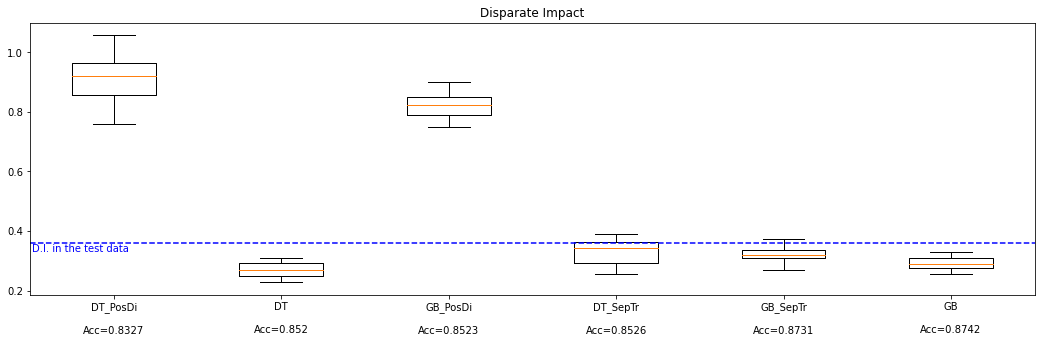

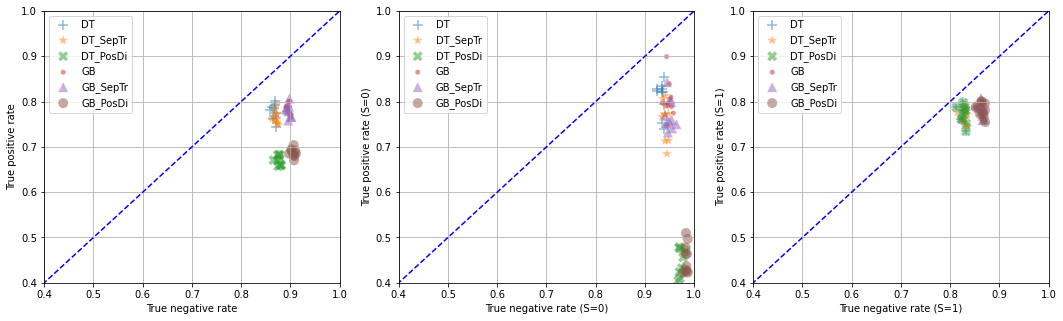

Average rates DT:
 -> True positive (all/S=0/S=1): 0.78 0.81 0.77
 -> True negative (all/S=0/S=1): 0.87 0.93 0.83
Average rates DT_SepTr:
 -> True positive (all/S=0/S=1): 0.77 0.76 0.77
 -> True negative (all/S=0/S=1): 0.87 0.94 0.83
Average rates DT_PosDi:
 -> True positive (all/S=0/S=1): 0.67 0.45 0.77
 -> True negative (all/S=0/S=1): 0.88 0.97 0.83
Average rates GB:
 -> True positive (all/S=0/S=1): 0.78 0.8 0.78
 -> True negative (all/S=0/S=1): 0.9 0.95 0.86
Average rates GB_SepTr:
 -> True positive (all/S=0/S=1): 0.78 0.77 0.78
 -> True negative (all/S=0/S=1): 0.9 0.95 0.86
Average rates GB_PosDi:
 -> True positive (all/S=0/S=1): 0.69 0.45 0.78
 -> True negative (all/S=0/S=1): 0.91 0.98 0.86


In [ ]:
    
S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_LR_CS=Clf_with_ClassSpecDecRules(clf_LR,X_col_names.index('Sex'),ReturnBestPred=False)
clf_LR_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_LR,X_col_names.index('Sex'))

clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT_CS=Clf_with_ClassSpecDecRules(clf_DT,X_col_names.index('Sex'),ReturnBestPred=False)
clf_DT_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_DT,X_col_names.index('Sex'))
    
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_GB_CS=Clf_with_ClassSpecDecRules(clf_GB,X_col_names.index('Sex'),ReturnBestPred=False)
clf_GB_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_GB,X_col_names.index('Sex'))


"""
list_classifiers=[clf_LR,clf_LR_CS,clf_LR_AdapThresh,
                  clf_DT,clf_DT_CS,clf_DT_AdapThresh,
                  clf_GB,clf_GB_CS,clf_GB_AdapThresh]
list_classifierNames=['LR','LR_SepTr','LR_PosDi',
                      'DT','DT_SepTr','DT_PosDi',
                      'GB','GB_SepTr','GB_PosDi']
"""

list_classifiers=[clf_DT,clf_DT_CS,clf_DT_AdapThresh,
                  clf_GB,clf_GB_CS,clf_GB_AdapThresh]
list_classifierNames=['DT','DT_SepTr','DT_PosDi',
                      'GB','GB_SepTr','GB_PosDi']

nsplits=10



PreFigNam='Summary'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,Show_DI_boxPlotsOnly=True,PrefixFigNames=PreFigNam)


Il convient de noter que les diagrammes en boîte ci-dessus sont classés de gauche à droite en fonction de la précision des prédictions. Ces résultats permettent de tirer plusieurs conclusions :

- Dans tous les cas testés, *Gradient Boosting* (GB) était plus précis que *Decision Trees* (DT), et DT était plus précis que *Logistic Regression* (LR).
- Toutes les méthodes avec les seuils originaux de 0,5 sur la probabilité de succès prédite avaient des *impacts discriminants* (ID) moyens inférieurs à l'ID moyen mesuré sur les données de test (environ 0,36).
- Une forte modification des seuils pour lesquels les prédictions conduisant à un succès dans la classe $S=0$ permet d'atteindre des *impacts discriminants* de 0,8. Cela s'est toutefois fait au prix d'une nette diminution de la précision des prédictions.
- La séparation des modèles de prédiction pour les observations avec $S=0$ et celles avec $S=1$ a permis d'augmenter simultanément le *DI* et la précision de prédiction pour *DT* et *LR*. Pour *GB*, le *DI* a été amélioré pour une précision de prédiction très légèrement inférieure.


### Références

Barocas S., Selbst A. (2016). Big Data's Disparate Impact, California Law Review, 671.

Dan Biddle (2005). Adverse Impact And Test Validation: A Practitioner's Guide to Valid And Defensible Employment Testing. Aldershot, Hants, England: Gower Technical Press. 

Hardt M., Price E., Srebro N. (2016). Equality of Opportunity in Supervised Learning. Proceedings of NIPS'16.

Besse P. ,del Barrio E., Gordaliza P., Loubes J.-M. (2018). Confidence Intervals for testing Disparate Impact in Fair Learning, <a href="https://arxiv.org/abs/1807.06362">arXiv</a>.

Calders T., Verwer S. (2010). Three naive Bayes approaches for discrimination-free classification, Data Mining and Knowledge Discovery, 21 (2), pp 277–292.

Friedler S., Scheidegger C., Venkatasubramanian S., Choudhary S., Hamilton E., Roth D. (2019). A comparative study of fairness-enhancing interventions in machine learning, Proceedings of the Conference on Fairness, Accountability, and Transparency.

Verma S., Rubin J. (2018). <a href="http://fairware.cs.umass.edu/papers/Verma.pdf">Fairness Definitions Explained</a>, ACM/IEEE International Workshop on Software Fairness.

